In [ ]:
# !brew install svn

In [ ]:
# if using mac, please run `brew install svn` to use svn

# ! svn export https://github.com/LabForComputationalVision/bias_free_denoising/trunk/data/Train400

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys


import sys

sys.path.append("/content/drive/MyDrive/Denoising Code/Denoising_Tutorial")
# sys.path.append("/content/drive/MyDrive/CVPR2024/sam_code/utils")

In [ ]:
path_to_image_data = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/dataset/5'

In [ ]:
path_to_saved_models = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/image_wavelet/saved_models/'

In [ ]:
import os

from PIL import Image

import numpy as np
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

import cv2
# from skimage.measure.simple_metrics import compare_psnr
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import glob
import pickle

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import argparse
import sys
import torchvision
import torch
from torch.serialization import default_restore_location
from torch.distributions import Poisson
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
sys.path.append('/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising')
import data
import models
import utils

In [ ]:
device = torch.device('cpu')

In [ ]:
noise_scale = 2

In [ ]:
kernel_size = 2
# noise_std_array = [float(10)/255, float(25)/255, float(55)/255];

n_examples = 3 #number of examples to plot

In [ ]:
import sys
# sys.path.append('/scratch/kl3141/Denoising_Tutorial/electron-microscopy-denoising')
sys.path.append('/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/image_wavelet')
sys.path.append('/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/image_wavelet/multiscale_py/')

import image_dataset
import haar_soft_threshold_2d_net
import linearcnn

In [ ]:
image_dataset

<module 'image_dataset' from '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/image_wavelet/image_dataset.py'>

In [ ]:
net = linearcnn.linearcnn(kernel_size=3);

1


### Plot Function for Filter

In [ ]:
def plot_matrix_color_and_numbers(ax = None, matrix = None, display_num = False, figsize = (20, 5), title_string = None, ax_off = False):

    if ax is None:
        fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=figsize);

    img_display = ax.matshow( matrix, cmap=plt.cm.Blues)

    if(display_num):
        for i in range(matrix.shape[1]):
            for j in range(matrix.shape[0]):
                c = matrix[j,i]
                ax.text(i, j, "{:.2f}".format(c), va='center', ha='center')

    ax.set_xlabel('Min: '+ "{:.2f}".format(np.min(matrix)) + ' Max: '+ "{:.2f}".format(np.max(matrix)) +' Mean: ' + "{:.2f}".format(np.mean(matrix)))

    if title_string is not None:
        ax.set_title(title_string)

    if ax_off:
        ax.axis('off')

    return img_display

def visualize_filters(net):
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 5));
    plt.setp(axes.flat,  adjustable='box-forced');

    axes[0].set_title('Filter');
    axes[1].set_title('FFT');

    filter_np = net.first_layer.weight.cpu().data.numpy()[0,0]
    plot_matrix_color_and_numbers(axes[0],
                                  filter_np, net.kernel_size < 6)

    fft_matrix = abs( np.fft.fftshift( np.fft.fft2( filter_np, s=(180,180))) );
    plot_matrix_color_and_numbers(axes[1], fft_matrix, False)


### Creating Dataloader

n_val random images are set for validation while rest of the images are in training

In [ ]:
n_val = 25;
files_source = glob.glob(os.path.join(path_to_image_data, '*.tif'))
files_source = np.sort(files_source)
list_val_images = files_source[-n_val:]
list_train_images = list( set(files_source) - set(list_val_images));

In [ ]:
list_train_images

[]

In [ ]:
# class Dataset(torch.utils.data.Dataset):
# 	def __init__(self,  list_of_image_path, resize_to_256 = False):
# 		super(Dataset, self).__init__()

# 		self.n_data = len(list_of_image_path)

# 		self.data_list = [None]*self.n_data;
# 		for i in range(self.n_data):

# 			f = list_of_image_path[i];
# 			Img = np.array(Image.open(f).resize((256,256)))
# # 			Img = self.normalize(np.float32(Img[:,:]))
# 			if resize_to_256:
# 			    Img = cv2.resize(Img, (256, 256))
# 			self.data_list[i] = Img;

# 	def __len__(self):
# 		return self.n_data

# 	def __getitem__(self, index):
# 		data = self.data_list[index]
# 		return torch.Tensor(data).unsqueeze(0);

# 	def normalize(self, data):
# 		return data/255.


In [ ]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

class Dataset(torch.utils.data.Dataset):
    def __init__(self, list_of_image_path):
        super(Dataset, self).__init__()

        self.n_data = len(list_of_image_path)
        self.data_list = [None] * self.n_data

        # Random cropping transform, crop size can be changed
        self.transform = transforms.RandomCrop(224)

        for i in range(self.n_data):
            f = list_of_image_path[i]
            Img = np.array(Image.open(f))  # Directly read the image without resizing
            self.data_list[i] = Img

    def __len__(self):
        return self.n_data

    def __getitem__(self, index):
        data = self.data_list[index]
        data = Image.fromarray(data.astype('uint8'))  # Convert np.array to PIL Image for applying transform
        data = self.transform(data)  # Apply random cropping
        data = np.array(data)  # Convert back to np.array
        return torch.Tensor(data).permute(2, 0, 1).float()  # Change dimensions to CxHxW and convert to float

    def normalize(self, data):
        return data / 255.

# Example usage:
# list_of_image_path = ["image1.jpg", "image2.jpg"]  # Replace with actual image paths
# dataset = Dataset(list_of_image_path)


In [ ]:
# dataset = 'ptceo2'
# dataset = 'ptceo2_resized'
dataset = 'ptceo2'
contrast = 'white'
# data_path = '/scratch/sm7582/prince/sm7582/datasets/Nanoparticles/ptceo2-1024'
data_path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images'
batch_size = 1

USE_CUDA = False
device = torch.device("cuda") if (
        torch.cuda.is_available() and USE_CUDA) else torch.device("cpu")

In [ ]:
# train_dataset = Dataset(list_train_images,
#                                          resize_to_256 = True)
# val_dataset = Dataset(list_val_images,
#                                        resize_to_256 = True)

# train_loader = DataLoader(dataset=train_dataset,
#                           num_workers=0,
#                           batch_size=128, shuffle=True);

# val_loader = DataLoader(dataset = val_dataset,
#                        num_workers = 0,
#                        batch_size = 32,
#                        shuffle = True)

In [ ]:
train_loader, val_loader, test_loader = data.build_dataset(dataset, data_path,
                                           test_batch_size=batch_size, rotation_aug = False, resize_aug=False,
                                           contrast = contrast, num_workers=0,image_size=256)

In [ ]:
train_dataset = train_loader.dataset
val_dataset = val_loader.dataset
test_dataset = test_loader.dataset

In [ ]:
train_dataset[1]['image'].size()

torch.Size([1, 256, 256])

In [ ]:
len(train_dataset)

353

In [ ]:
len(val_dataset)

19

In [ ]:
len(test_dataset)

22

In [ ]:
353 + 19 + 22

394

In [ ]:
val_dataset[1]['image'].size()

torch.Size([1, 256, 256])

In [ ]:
test_dataset[1]['image'].size()

torch.Size([1, 256, 256])

# Image Statstics

In [ ]:
def find_expected_coeff_square(train_dataset):
    n = len(train_dataset)
    abs_coeff_mat = 0;

    for i in range(n):
        temp = np.fft.fftshift( np.fft.fft2(train_dataset[i]['image'].data[0].numpy() ) )
        abs_coeff_mat += (np.absolute(temp) ** 2)

    abs_coeff_mat /= n

    return abs_coeff_mat

In [ ]:
mean_coeff_sq = find_expected_coeff_square(train_dataset)

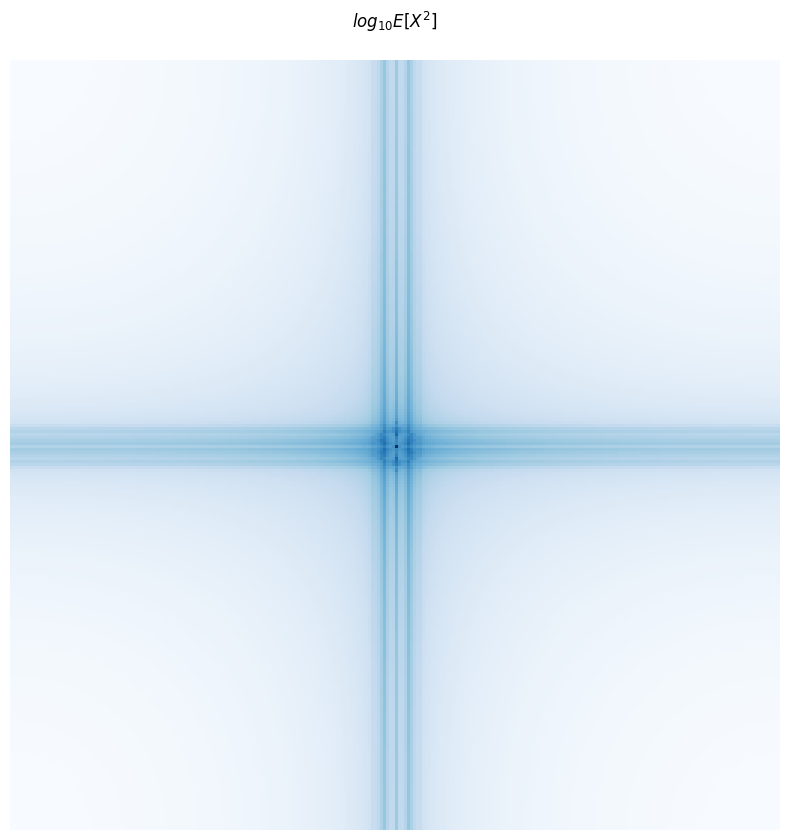

In [ ]:
plot_matrix_color_and_numbers(ax = None, matrix = np.log10(mean_coeff_sq), display_num=False, title_string='$log_{10}E[X^2]$', figsize=(10, 10), ax_off = True)

In [ ]:
def convert_2d_plot_to_1d(abs_coeff_mat):

    zero_x = abs_coeff_mat.shape[0]//2;
    zero_y = abs_coeff_mat.shape[1]//2;

    f_array = np.zeros(abs_coeff_mat.shape[0] * abs_coeff_mat.shape[1]);
    coeff_array = np.zeros(abs_coeff_mat.shape[0] * abs_coeff_mat.shape[1]);
    for i in range(abs_coeff_mat.shape[0]):
        for j in range(abs_coeff_mat.shape[1]):
            f_array[i*abs_coeff_mat.shape[1] + j] = np.sqrt((i-zero_x)**2 + (j-zero_y)**2);
            coeff_array[i*abs_coeff_mat.shape[1] + j] = abs_coeff_mat[i, j]

    sort_idx = np.argsort(f_array)
    coeff_array =  coeff_array[sort_idx]
    f_array = f_array[sort_idx]

    unique_f = np.unique(f_array)
    m = len(unique_f);

    unique_coeff = np.zeros(m);

    for i, x in enumerate(unique_f):
        same_idx = np.where(unique_f == x)[0];
        unique_coeff[i] = np.mean(coeff_array[same_idx]);

    return unique_f, unique_coeff

In [ ]:
f_1d, mean_sq_coeff_1d = convert_2d_plot_to_1d(mean_coeff_sq);

Text(0.5, 1.0, '$log_{10}E[X^2]$ in 1D')

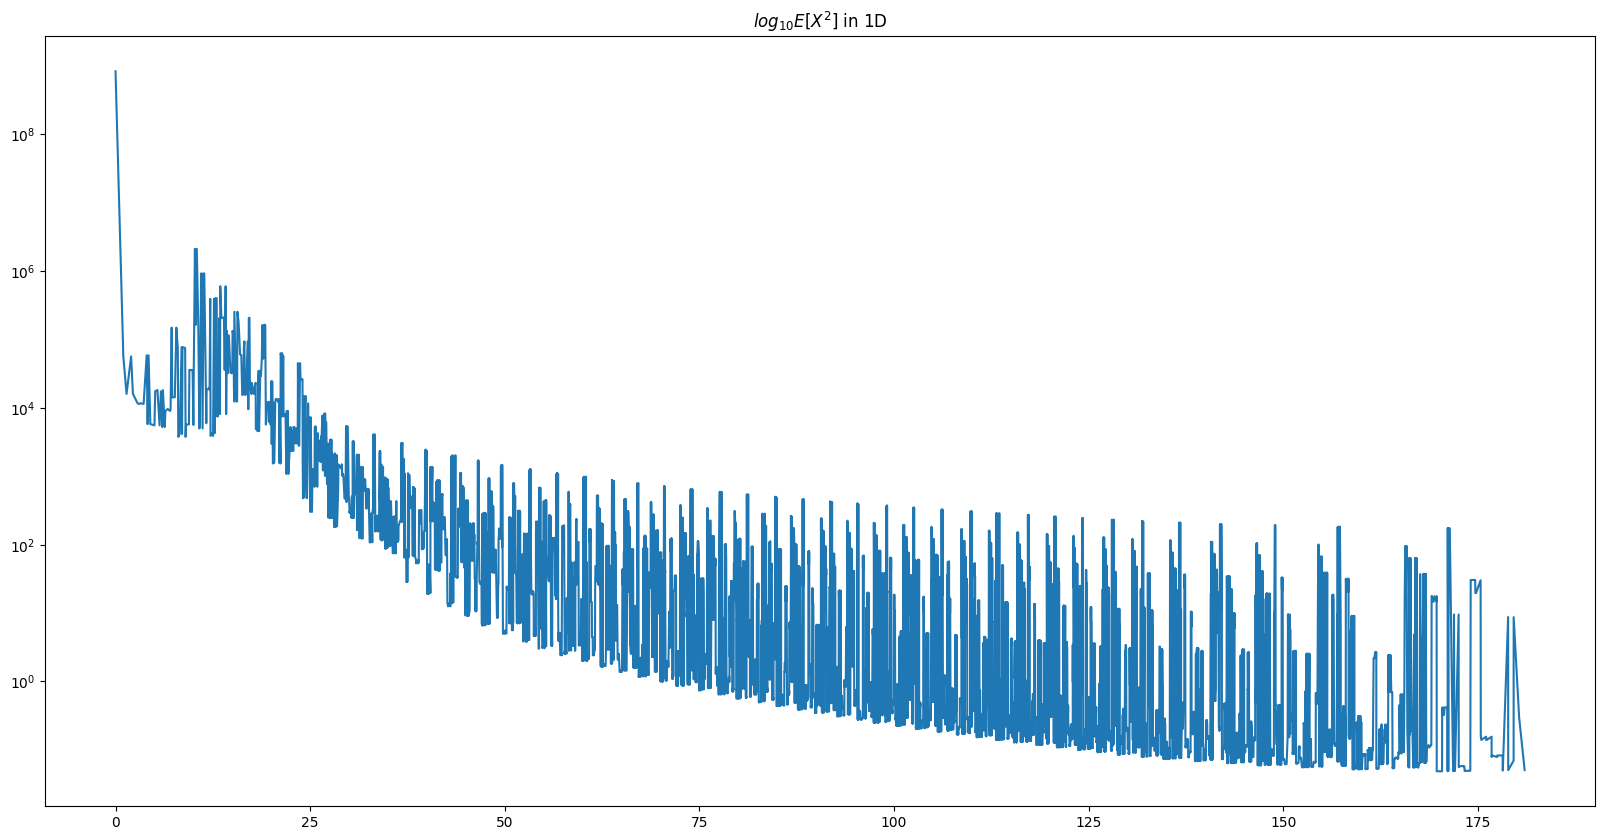

In [ ]:
plt.figure(figsize = (20, 10))
plt.semilogy(f_1d, mean_sq_coeff_1d)
plt.title('$log_{10}E[X^2]$ in 1D')

## Look at Examples

In [ ]:
def batch_PSNR(img, imclean, data_range):
    Img = img.data.cpu().numpy().astype(np.float32)
    Iclean = imclean.data.cpu().numpy().astype(np.float32)
    PSNR = 0
    for i in range(Img.shape[0]):
        PSNR += compare_psnr(Iclean[i,:,:,:], Img[i,:,:,:], data_range=data_range)
    return (PSNR/Img.shape[0])

In [ ]:
def normalize(data):
    return data/255.

def get_test_image(path_to_dataset, index):
    files_source = glob.glob(os.path.join(path_to_dataset, '*.png'))
    files_source.sort()

    f = files_source[index];

    Img = cv2.imread(f)
    Img = normalize(np.float32(Img[:,:,0]))
    Img = np.expand_dims(Img, 0)
    Img = np.expand_dims(Img, 1)
    ISource = torch.Tensor(Img).to(device)

    return ISource


In [ ]:
from torch.distributions import Poisson

In [ ]:
def get_noise(data, noise_std = 0.1, mode='poisson', max_noise = 5e-1, noise_scale=50):
    if mode=='poisson':
        source = data
        scaled_source = source * noise_scale
        # Generate Poisson noise sample based on the scaled source
        noise_sample = Poisson(scaled_source).sample()
        # Scale back the generated noise
        noise_sample = (noise_sample - scaled_source) / noise_scale
        noise = noise_sample
    else:
        noise = get_noise_others(data, noise_std, mode, max_noise)
    return noise

def get_noise_others(data, noise_std = 0.1, mode='S', max_noise = 5e-1):
    noise = torch.randn_like(data);
    if mode == 'B':
        n = noise.shape[0];
        noise_tensor_array = max_noise * torch.rand(n);
        for i in range(n):
            noise.data[i] = noise.data[i] * noise_tensor_array[i];
    else:
        noise.data = noise.data * noise_std;
    return noise

In [ ]:
def tensor_to_image(torch_image, low=0.0, high = 1.0, clamp = True):
    if clamp:
        torch_image = torch.clamp(torch_image, low, high);
    return torch_image[0,0].cpu().data.numpy()

In [ ]:
def plot_2d_log_fft(image, ax = None, ax_off = True, title_string = None):
    fft = np.fft.fftshift( np.fft.fft2(image) );
    mat = np.log10( np.abs(fft) + 1e-9)

    if title_string is None:
        return plot_matrix_color_and_numbers(ax = ax, matrix=mat, display_num=False, ax_off = ax_off)
    else:
        return plot_matrix_color_and_numbers(ax = ax, matrix=mat, display_num=False, title_string = title_string, ax_off = ax_off)


In [ ]:
# def visualize_denoising(source, net, noise_sample = None, figsize = (20, 20)):
#     fig, axes = plt.subplots(2, 3, sharex=True, sharey='row', figsize=figsize);

#     axes[0, 0].imshow(tensor_to_image(source), cmap='gray')
#     axes[0, 0].axis('off')
#     plot_2d_log_fft(tensor_to_image(source), axes[1, 0]);

#     print(source[0,0].size())

#     if noise_sample is None:
# #         noise_sample = get_noise(source, noise_std);
#         noise_sample = Poisson(source).sample()

#     noisy = source + noise_sample;
# #     noisy = noise_sample

# #     noisy = source

#     axes[0, 1].imshow(tensor_to_image(noisy), cmap='gray')
#     axes[0, 1].axis('off')
#     axes[0, 1].set_title(str(batch_PSNR(noisy, source, 1.)))
#     plot_2d_log_fft(tensor_to_image(noisy), axes[1, 1]);

#     denoised = net(noisy);


#     axes[0, 2].imshow(tensor_to_image(denoised), cmap='gray')
#     axes[0, 2].axis('off')
#     axes[0, 2].set_title(str(batch_PSNR(torch.clamp(denoised, 0.0, 1.0), source, 1.)))
#     plot_2d_log_fft(tensor_to_image(denoised), axes[1, 2]);

# #     plt.tight_layout()
#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.show()

In [ ]:
from torch.distributions import Poisson
import matplotlib.pyplot as plt
# Assume tensor_to_image, plot_2d_log_fft, and batch_PSNR are defined elsewhere

def visualize_denoising(source, net, noise_sample=None, noise_scale=1.0, figsize=(20, 20)):
    fig, axes = plt.subplots(2, 3, sharex=True, sharey='row', figsize=figsize)

    axes[0, 0].imshow(tensor_to_image(source), cmap='gray')
    axes[0, 0].axis('off')
    plot_2d_log_fft(tensor_to_image(source), axes[1, 0])

    print(source[0, 0].size())

#     if noise_sample is None:
#         # Scale the source tensor to control the noise level
#         scaled_source = source * noise_scale
#         # Generate Poisson noise sample based on the scaled source
#         noise_sample = Poisson(scaled_source).sample()
#         # Scale back the generated noise
#         noise_sample = (noise_sample - scaled_source) / noise_scale



#     noisy = source + noise_sample
    if noise_sample is None:
        noisy  = source + get_noise(source, noise_scale = noise_scale)

    axes[0, 1].imshow(tensor_to_image(noisy), cmap='gray')
    axes[0, 1].axis('off')
    axes[0, 1].set_title(str(batch_PSNR(noisy, source, 1.0)))
    plot_2d_log_fft(tensor_to_image(noisy), axes[1, 1])

    denoised = net(noisy)

    axes[0, 2].imshow(tensor_to_image(denoised), cmap='gray')
    axes[0, 2].axis('off')
    axes[0, 2].set_title(str(batch_PSNR(torch.clamp(denoised, 0.0, 1.0), source, 1.0)))
    plot_2d_log_fft(tensor_to_image(denoised), axes[1, 2])

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

# Note: The function now accepts an additional parameter 'noise_scale'
# You can adjust 'noise_scale' to control the level of noise.


### Visalizing Before Training

In [ ]:
val_dataset[0]

{'image': tensor([[[0.3614, 0.3516, 0.3420,  ..., 0.3443, 0.3370, 0.3304],
          [0.3733, 0.3628, 0.3523,  ..., 0.3526, 0.3444, 0.3369],
          [0.3860, 0.3747, 0.3635,  ..., 0.3618, 0.3528, 0.3444],
          ...,
          [0.4188, 0.4319, 0.4446,  ..., 0.2697, 0.2690, 0.2694],
          [0.4209, 0.4337, 0.4460,  ..., 0.2703, 0.2700, 0.2709],
          [0.4235, 0.4360, 0.4479,  ..., 0.2713, 0.2715, 0.2728]]]),
 'name': '40A-04x-00y-18nm',
 'thickness': 40,
 'tilt_x': 4,
 'tilt_y': 0,
 'defocus': 18,
 'contrast': 'white',
 'particle': 'PtNp2-D1'}

In [ ]:
train_dataset[0]['image'].size()

torch.Size([1, 256, 256])

In [ ]:
# noise_std = np.random.choice(noise_std_array)
for i in range(n_examples):
    visualize_denoising(val_dataset[i]['image'].unsqueeze(0).to(device), net, figsize=(20, 10), noise_scale=noise_scale)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
from PIL import Image
import torch
path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
# image_np = np.array(Image.open(path).resize((256,256)))
image_np = np.array(Image.open(path))


image_tensor = torch.tensor(image_np).unsqueeze(0).unsqueeze(0)
# clean_tmpt = image_tensor.unsqueeze(0)

# for noise_std in noise_std_array:
#     print('='*50 +'\n\n')
print('Possion Distribution')
visualize_denoising(image_tensor.to(device), net, figsize=(20, 10))
    # visualize_best_wiener_denoising(image_tensor, noise_std, wiener_star[noise_std], fft_sample=(image_np.shape[0], image_np.shape[1]))

Output hidden; open in https://colab.research.google.com to view.

## Theoretical Wiener Filter

In [ ]:
# def get_noise_possion(data, noise_std = 0.1, mode='S', max_noise = 5e-1):
#     noise = torch.randn_like(data);
#     if mode == 'B':
#         n = noise.shape[0];
#         noise_tensor_array = max_noise * torch.rand(n);
#         for i in range(n):
#             noise.data[i] = noise.data[i] * noise_tensor_array[i];
#     else:
#         noise.data = noise.data * noise_std;
#     return noise

In [ ]:
def theoretical_wiener_from_data(train_dataset, fft_shift = True, fft_sample = (256, 256),  n = 10, noise_scale=50):
    mean_coeff = np.fft.fft2(train_dataset[0]['image'].numpy()[0], s = fft_sample) * 0;

    for i in range(n):
        for x in train_dataset:
#             print(x)
            x = x['image']
#             noisy = x + get_noise(x, noise_std=noise_std);
            source = x
#             scaled_source = source * noise_scale
#             # Generate Poisson noise sample based on the scaled source
#             noise_sample = Poisson(scaled_source).sample()
#             # Scale back the generated noise
#             noise_sample = (noise_sample - scaled_source) / noise_scale
#             noisy = source + noise_sample

            noisy = source+ get_noise(source, mode = 'poisson', noise_scale=noise_scale);
#             noisy = Poisson(x).sample()
#             print(noisy.size())
            noise_fft = ( np.fft.fft2(noisy.numpy()[0], s = fft_sample) );
            clean_fft = ( np.fft.fft2(x.numpy()[0], s = fft_sample) );

            mean_coeff += clean_fft * np.conjugate(noise_fft) / np.abs(noise_fft+1*10**(-8))**2

    mean_coeff /= n*len(train_dataset)
    if fft_shift:
        return np.fft.fftshift(mean_coeff)
    else:
        return mean_coeff

In [ ]:
def theoretical_wiener_from_data(train_dataset, fft_shift = True, fft_sample = (256, 256),  n = 10, noise_scale=50, regularization=1e-8):
    mean_coeff = np.fft.fft2(train_dataset[0]['image'].numpy()[0], s = fft_sample) * 0;

    for i in range(n):
        for x in train_dataset:
#             print(x)
            x = x['image']
#             noisy = x + get_noise(x, noise_std=noise_std);
            source = x
#             scaled_source = source * noise_scale
#             # Generate Poisson noise sample based on the scaled source
#             noise_sample = Poisson(scaled_source).sample()
#             # Scale back the generated noise
#             noise_sample = (noise_sample - scaled_source) / noise_scale
#             noisy = source + noise_sample

            noisy = source+ get_noise(source, mode = 'poisson', noise_scale=noise_scale);
#             noisy = Poisson(x).sample()
#             print(noisy.size())
            noise_fft = ( np.fft.fft2(noisy.numpy()[0], s = fft_sample) );
            clean_fft = ( np.fft.fft2(x.numpy()[0], s = fft_sample) );

            mean_coeff += clean_fft * np.conjugate(noise_fft) / (np.abs(noise_fft + regularization)**2 )

    mean_coeff /= n*len(train_dataset)
    if fft_shift:
        return np.fft.fftshift(mean_coeff)
    else:
        return mean_coeff

In [ ]:
# def theoretical_wiener_from_expected_coeff_sq(mean_coeff_sq, noise_std, n):
#     return mean_coeff_sq/( mean_coeff_sq +  (n*noise_std)**2 )

In [ ]:
def plot_filter_and_fft_from_fft(fft_mat, s= 17):
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 5));

    axes[0].set_title('Filter');
    axes[1].set_title('$log_{10}(FFT)$');

    filter_np = np.real( np.fft.ifft2( np.fft.ifftshift(fft_mat), s = (s, s) ) );

    plot_matrix_color_and_numbers(axes[0],
                                  filter_np, display_num = (s < 7) );


    plot_matrix_color_and_numbers(axes[1], (np.abs(fft_mat)), False);


### Visualizing filters

In [ ]:
noise_scale

2

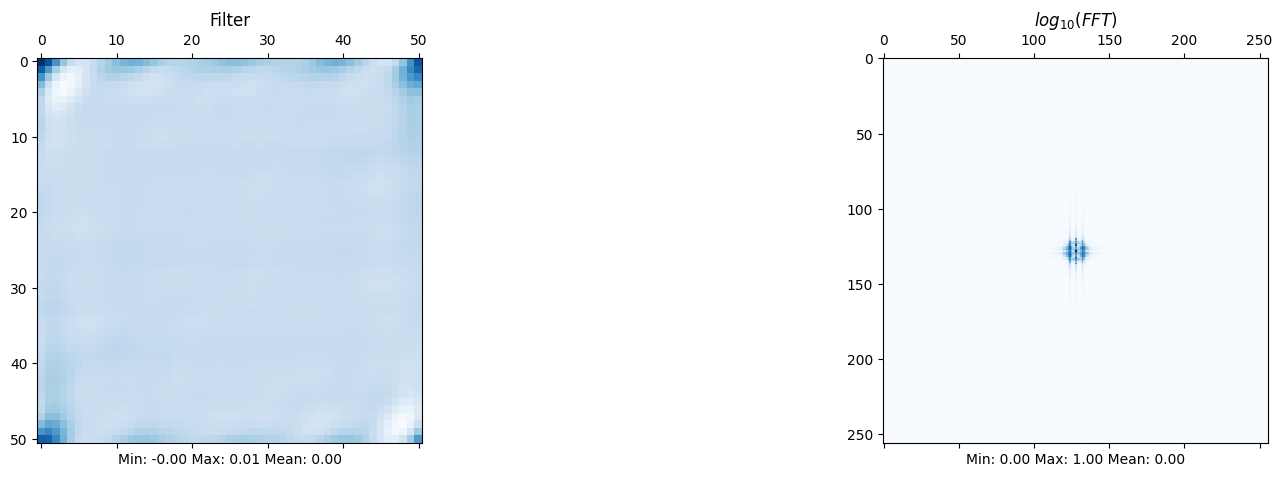

In [ ]:
wiener_star = theoretical_wiener_from_data(train_dataset,noise_scale=noise_scale, fft_sample = (256, 256), regularization=1e-4)
#     wiener_star = theoretical_wiener_from_expected_coeff_sq(mean_coeff_sq, noise_std, len(train_dataset));
plot_filter_and_fft_from_fft(wiener_star, s = 51)
plt.show()

In [ ]:
wiener_star.shape

(256, 256)

### Visualize Theoretical Wiener Denoising

In [ ]:
def best_wiener_loss_and_psnr(val_dataset, wiener_star, fft_sample= (256, 256),noise_scale=1):
    mean_loss = 0;
    mean_psnr = 0;
    mean_noisy_psnr = 0;
    for source in val_dataset:
#         noisy = source + get_noise(source, noise_std=noise_std)
        source = source['image']
#         noisy = Poisson(source).sample()
#         source = source.numpy()[0]
#         noisy = noisy.numpy()[0]

#         scaled_source = source * noise_scale
#         # Generate Poisson noise sample based on the scaled source
#         noise_sample = Poisson(scaled_source).sample()
#         # Scale back the generated noise
#         noise_sample = (noise_sample - scaled_source) / noise_scale
#         noisy = source + noise_sample
        noisy = source+ get_noise(source, mode = 'poisson', noise_scale=noise_scale);

        noisy = noisy.numpy()[0]


        #     noisy = Poisson(source).sample()
        #     noisy = noisy.numpy()[0]
        #     print(noisy.shape)
        source = source.numpy()[0]


        source_fft = np.fft.fftshift( np.fft.fft2(source, s = fft_sample) );
        noisy_fft = np.fft.fftshift( np.fft.fft2(noisy, s = fft_sample) );
        denoised_fft = noisy_fft * wiener_star;

        source_ifft = np.clip( np.real( np.fft.ifft2( np.fft.ifftshift(source_fft), s= fft_sample) ), 0., 1. );
        noisy_ifft = np.clip( np.real(np.fft.ifft2( np.fft.ifftshift( noisy_fft), s = fft_sample)), 0., 1. );
        denoised_ifft = np.clip( np.real( np.fft.ifft2( np.fft.ifftshift(denoised_fft), s = fft_sample)), 0., 1. );

        mean_loss += np.linalg.norm(denoised_ifft - source_ifft)**2;
        mean_psnr += compare_psnr(source_ifft, denoised_ifft, data_range=1.)
        mean_noisy_psnr += compare_psnr(source_ifft, noisy, data_range=1.)
    print(mean_noisy_psnr/len(val_dataset))

    return mean_loss/len(val_dataset), mean_psnr/len(val_dataset)

In [ ]:
def visualize_best_wiener_denoising(source, wiener_star, figsize = (20, 10), fft_sample = (256, 256), noise_scale=1):


#     noisy = source + get_noise(source, noise_std=noise_std)
#     source = source.numpy()[0]
#     noisy = noisy.numpy()[0]
#     print(noisy.shape)



#     scaled_source = source * noise_scale
#     # Generate Poisson noise sample based on the scaled source
#     noise_sample = Poisson(scaled_source).sample()
#     # Scale back the generated noise
#     noise_sample = (noise_sample - scaled_source) / noise_scale
#     noisy = source + noise_sample

    noisy = source+ get_noise(source, mode = 'poisson', noise_scale=noise_scale);

    noisy = noisy.numpy()[0]


#     noisy = Poisson(source).sample()
#     noisy = noisy.numpy()[0]
#     print(noisy.shape)
    source = source.numpy()[0]

    source_fft = np.fft.fftshift( np.fft.fft2(source, s = fft_sample) );
    noisy_fft = np.fft.fftshift( np.fft.fft2(noisy, s = fft_sample) );
    denoised_fft = noisy_fft * wiener_star;

    source_ifft = np.clip( np.real( np.fft.ifft2( np.fft.ifftshift(source_fft), s= fft_sample) ), 0., 1. );
    noisy_ifft = np.clip( np.real(np.fft.ifft2( np.fft.ifftshift( noisy_fft), s = fft_sample)), 0., 1. );
    denoised_ifft = np.clip( np.real( np.fft.ifft2( np.fft.ifftshift(denoised_fft), s = fft_sample)), 0., 1. );

    fig, axes = plt.subplots(2, 3, sharex=True, sharey='row', figsize=figsize);
    axes[0, 0].imshow( source_ifft, cmap = 'gray' )
    axes[0, 0].axis('off')
    plot_2d_log_fft(source_ifft, axes[1, 0]);

    axes[0,1].imshow( noisy_ifft, cmap='gray' )
    axes[0,1].set_title(str( compare_psnr(source_ifft, noisy_ifft, data_range=1.)) )
    axes[0,1].axis('off')
    plot_2d_log_fft(noisy_ifft, axes[1, 1]);


    axes[0,2].imshow(denoised_ifft, cmap = 'gray')
    axes[0,2].set_title(str( compare_psnr(source_ifft, denoised_ifft, data_range=1.)) )
    axes[0,2].axis('off')
    plot_2d_log_fft(denoised_ifft, axes[1, 2]);

    plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()

In [ ]:
# import numpy as np
# from PIL import Image
# import torch
# path = '/Users/liukangning/Downloads/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
# image_np = np.array(Image.open(path).resize((256,256)))


# image_tensor = torch.tensor(image_np).unsqueeze(0)
# clean_tmpt = image_tensor.unsqueeze(0)

In [ ]:
def center_crop(image_np, output_size=(256,256)):
    h, w = image_np.shape
    crop_h, crop_w = output_size

    start_x = w//2 - (crop_w//2)
    start_y = h//2 - (crop_h//2)

    return image_np[start_y:start_y+crop_h, start_x:start_x+crop_w]


In [ ]:
image_np.shape

(876, 927)

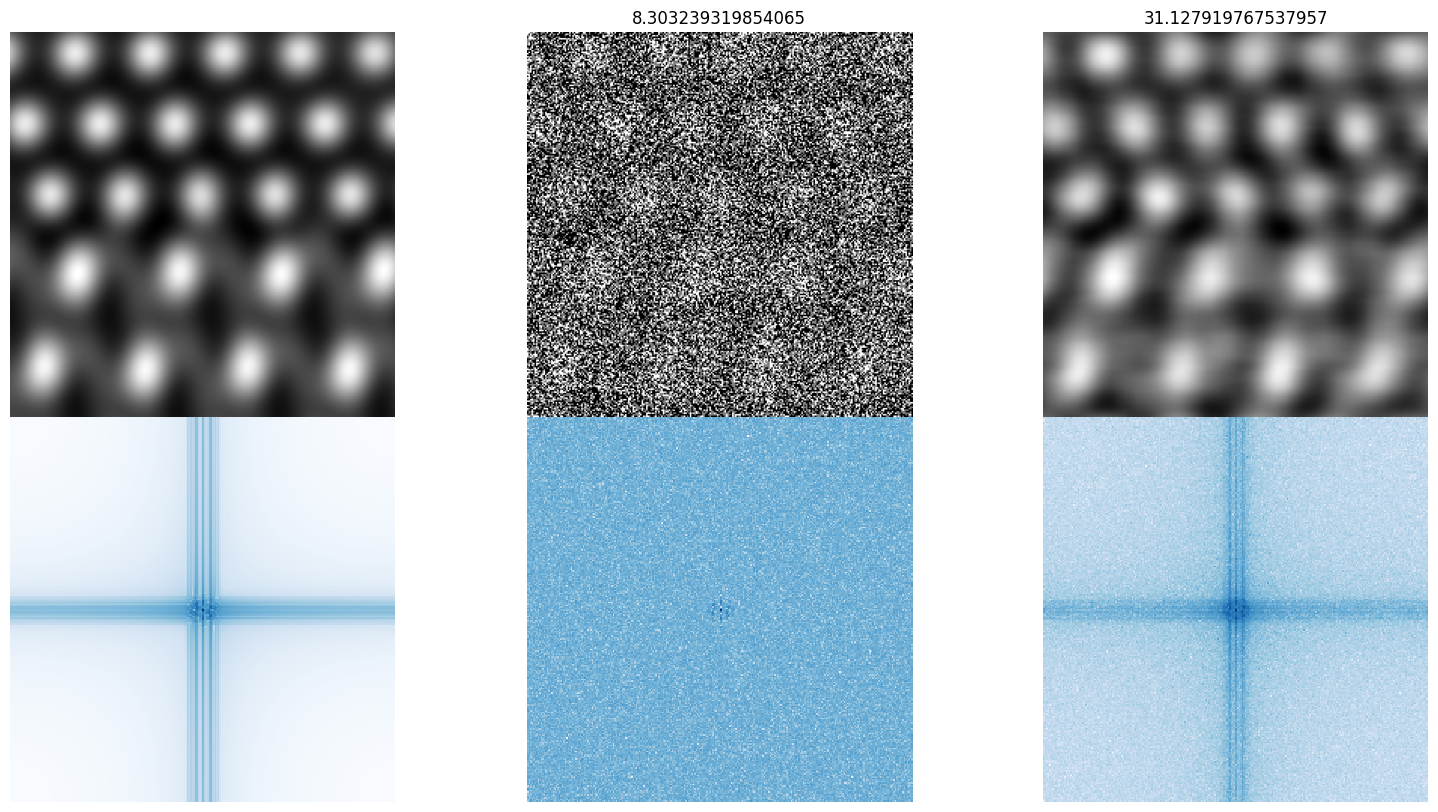

In [ ]:
import numpy as np
from PIL import Image
import torch
# path = '/Users/liukangning/Downloads/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
# image_np = np.array(Image.open(path).resize((256,256)))
image_np = np.array(Image.open(path))
image_np = center_crop(image_np, output_size=(256,256))



image_tensor = torch.tensor(image_np).unsqueeze(0)
clean_tmpt = image_tensor.unsqueeze(0)

# for noise_std in noise_std_array:
#     print('='*50 +'\n\n')
#     print('Noise Std: ', noise_std)

visualize_best_wiener_denoising(image_tensor, wiener_star, fft_sample=(image_np.shape[0], image_np.shape[1]), noise_scale=noise_scale)

### Performance of Theoretical Wiener

In [ ]:
# wiener_star_psnr_val_dict = {}
# for noise_std in noise_std_array:
# print('noise std: ', noise_std)
wiener_star_loss, wiener_star_psnr = best_wiener_loss_and_psnr(val_dataset, wiener_star, fft_sample = (256, 256),noise_scale=noise_scale)
print('Loss: ', wiener_star_loss)
print('PSNR: ', wiener_star_psnr)
# wiener_star_psnr_val_dict[noise_std] = wiener_star_psnr
print('='*50 + '\n')

6.625671261560511
Loss:  79.73915447788312
PSNR:  29.807817205609876



# One layer CNN without the nolinear activation function

Here we show that one layer CNN without nonlinear layers can not outperform Wiener filter. This was put into a wavelet framework and optimized over a dataset to minimize the mean squared error. Please look into the the folder `multiscale_py` for details on implementation

### Training

In [ ]:
kernel_size_list = [49];
onelayer_net_dict = {};

In [ ]:
def get_noise(data, noise_std = 0.1, mode='poisson', max_noise = 5e-1, noise_scale=1):
    if mode=='poisson':
        source = data
        scaled_source = source * noise_scale
        # Generate Poisson noise sample based on the scaled source
        noise_sample = Poisson(scaled_source).sample()
        # Scale back the generated noise
        noise_sample = (noise_sample - scaled_source) / noise_scale
        noise = noise_sample
    else:
        noise = get_noise_others(data, noise_std, mode, max_noise)
    return noise

def get_noise_others(data, noise_std = 0.1, mode='S', max_noise = 5e-1):
    noise = torch.randn_like(data);
    if mode == 'B':
        n = noise.shape[0];
        noise_tensor_array = max_noise * torch.rand(n);
        for i in range(n):
            noise.data[i] = noise.data[i] * noise_tensor_array[i];
    else:
        noise.data = noise.data * noise_std;
    return noise

In [ ]:
def validation_error_psnr(model, dataset_val, add_noise = False, noise_mode = 'poisson', noise_std=0.1, max_noise = 5e-1, noise_scale=1):
    model.eval()
    error_val = 0;
    psnr_val = 0;
    total_length = 0;

    criterion = nn.MSELoss(reduction = 'sum');

    for data in dataset_val:
        data = data['image']
#         data = data.resize((256,256))
        target = data.clone()

        if add_noise:
#             data = data + get_noise(data, noise_std, mode = noise_mode, max_noise = max_noise);
#             data = Poisson(data).sample()

            data = data + get_noise(data, mode = noise_mode,noise_std=noise_std, max_noise = max_noise, noise_scale=noise_scale)



#             scaled_source = source * noise_scale
#             # Generate Poisson noise sample based on the scaled source
#             noise_sample = Poisson(scaled_source).sample()
#             # Scale back the generated noise
#             noise_sample = (noise_sample - scaled_source) / noise_scale
#             noisy = source + noise_sample
# #             noisy = noisy.numpy()[0]
#             data = noisy
        data = data.to(device)
        target = target.to(device)
        out_val = model( data );

        error_val += criterion(out_val, target).item()
        psnr_val += ( batch_PSNR(out_val, target, 1.0) * data.shape[0] )
        total_length += data.shape[0];

    return error_val/total_length, psnr_val/total_length

In [ ]:
def train_network_on_noise(model, train_loader, val_loader,
                            add_noise = False, noise_mode = 'poisson', max_noise = 5e-1, noise_std = 0.1,
                            max_epoch = 50,  milestone = 50, lr=0.001, plot_loss = True, verbose = False,
                            verbose_freq = 100, early_stopping = True, noise_scale=1):
    model = model.to(device)

    optimizer = optim.Adam( filter(lambda p: p.requires_grad, model.parameters()) , lr=lr);
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience = 5, factor = 0.5)
    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    train_psnr = np.zeros(max_epoch);
    val_psnr = np.zeros(max_epoch);

    best_model = None;
    best_val_loss = np.inf;

    for epoch in range(max_epoch):

#         if epoch > milestone:
#             for param_group in optimizer.param_groups:
#                 param_group["lr"] = lr/10;

        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();
            data = data['image']
            target = data.clone();

            if add_noise:
#                 data = Poisson(data).sample()
                data = data + get_noise(data, mode = noise_mode, max_noise = max_noise, noise_scale=noise_scale);

            data = data.to(device)
            target = target.to(device)

            out_train = model(data);
            loss = criterion(out_train, target);
            loss.backward()
            optimizer.step()

        train_loss[epoch], train_psnr[epoch] = validation_error_psnr(model, train_loader,
                                                                add_noise = add_noise);
        val_loss[epoch], val_psnr[epoch] = validation_error_psnr(model, val_loader,
                                                            add_noise = add_noise);
        scheduler.step(val_psnr[epoch])

        if (epoch+1) % verbose_freq == 0 and verbose:
            print(epoch+1, 'train error: ', train_loss[epoch],
                             'val error: ', val_loss[epoch],
                              'train psnr: ', train_psnr[epoch],
                             'val psnr: ', val_psnr[epoch]);

        if val_loss[epoch] < best_val_loss:
            best_model = model.state_dict();
            best_val_loss = val_loss[epoch]

    if early_stopping:
        model.load_state_dict(best_model)

    if plot_loss:
        plt.semilogy(np.arange(1, max_epoch+1), train_loss, label = 'train loss');
        plt.semilogy(np.arange(1, max_epoch+1), val_loss, label = 'val loss')
        plt.legend()
        plt.show()

        plt.plot(np.arange(1, max_epoch+1), train_psnr, label = 'train psnr');
        plt.plot(np.arange(1, max_epoch+1), val_psnr, label = 'val psnr')
        plt.legend()
        plt.show()

    return model, train_psnr, val_psnr

In [ ]:
validation_dict = {}
# noise_std_array = [float(10)/255];

# for noise_std in noise_std_array:
# validation_dict[noise_std] ={}
# print('='*50)
# print('noise std: ', noise_std);

# string_noise_std = str(int(noise_std*1000));

net_dict_filename = 'onelayercnn_possion_crop.pth'

# net_dict_filename = 'onelayercnn_natural'+string_noise_scale+'.pth';

if os.path.exists(os.path.join(path_to_saved_models, net_dict_filename)):
    net_dict = pickle.load( open( os.path.join(path_to_saved_models, net_dict_filename), "rb" ) )
    onelayer_net_dict[noise_scale] = net_dict
    print('load pretained')

else:
    noise_scale = 1
    net_dict = {}
    print('Training..')
    for kernel_size in kernel_size_list:
        print(kernel_size)
        net_temp = linearcnn.linearcnn(kernel_size=kernel_size);

        net_temp, train_psnr_tmpt, val_psnr_tmpt = train_network_on_noise(net_temp, train_loader, val_loader,
                                add_noise = True,
                                noise_mode = 'S',
                                max_epoch = 30,
                                milestone = 100,
                                lr = 1e-1,
                                verbose = True,
                                verbose_freq = 5,
                                plot_loss = True)
    #             visualize_filters(net_temp)
        validation_dict[kernel_size] = val_psnr_tmpt
        plt.show()
        print('='*50)
        net_dict[kernel_size] = net_temp;
        pickle.dump(net_dict, open( os.path.join(path_to_saved_models, net_dict_filename), "wb" ) )
    onelayer_net_dict[noise_scale] = net_dict;

load pretained


In [ ]:
# kernal_size = 3
# max_epoch=30
# # for noise_std in noise_std_array:
# validation_dict[kernal_size]
# #     plt.plot(np.arange(1, max_epoch+1), train_psnr, label = 'train psnr');
# plt.plot(np.arange(1, max_epoch+1), validation_dict[kernel_size_list[0]], label = 'kernal_size' + str(kernel_size_list[0]))
# #     plt.plot(np.arange(1, max_epoch+1), validation_dict[noise_std][kernel_size_list[1]], label = 'kernal_size' + str(kernel_size_list[1]))
# #     plt.plot(np.arange(1, max_epoch+1), validation_dict[noise_std][kernel_size_list[2]], label = 'kernal_size' + str(kernel_size_list[2]))
# plt.axhline(y=wiener_star_psnr, color="red", linestyle="-", label = 'wiener')
# plt.xlabel('training epochs')
# plt.ylabel('validation psnr')
# #     plt.title('noise level ' + str(noise_std))
# plt.legend()
# plt.show()


### Val MSE and PNR for different kernel size

In [ ]:
best_kernel_size = {};
# kernel_size_list = [3]
# for noise_std in noise_std_array:

# print('noise std: ', noise_std)
best_kernel_psnr = 0;
best_kernel = 0;
for kernel_size in kernel_size_list:
    val_loss, val_psnr= validation_error_psnr(onelayer_net_dict[noise_scale][kernel_size], val_loader,
                                                            add_noise = True);
    print('Kernel Size: ', kernel_size, 'Val MSE: ', val_loss, 'Val PSNR: ', val_psnr)
#         visualize_filters(net_dict[kernel_size])
    plt.show()
    if val_psnr > best_kernel_psnr:
        best_kernel_psnr = val_psnr;
        best_kernel = kernel_size;

best_kernel_size = best_kernel;
print('='*50 + '\n\n')

Kernel Size:  49 Val MSE:  9547.861071134868 Val PSNR:  8.366564441744252




In [ ]:
# onelayer_net_dict[noise_scale][49].conv1.weight

In [ ]:
# onelayer_net_dict[noise_scale][49].conv1.bias

# DNN Training

## Training with Continuous Noise Sampling or Not

In [ ]:
sys.path.append('/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising')
sys.path.append('/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/models_microscopy')

import models_microscopy

In [ ]:
diff_checkpoint_path = {
    'White-4-128': '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/checkpoints/unet-128-small.pt',
    'White-6-128': '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/checkpoints/unet-128-big.pt',
}

In [ ]:
dataset = 'ptceo2'
contrast = 'white'
# data_path = '/scratch/sm7582/prince/sm7582/datasets/Nanoparticles/ptceo2-1024'
data_path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images'
batch_size = 1


# depending on whether GPU is available
USE_CUDA = False
device = torch.device("cuda") if (
        torch.cuda.is_available() and USE_CUDA) else torch.device("cpu")

In [ ]:
def load_model(checkpoint_path):
    state_dict = torch.load( checkpoint_path, map_location=lambda s,
                                l: default_restore_location(s,"cpu"))

    args = argparse.Namespace(
        **{**vars(state_dict["args"])})
    model = models_microscopy.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model

In [ ]:
def load_model_fromscratch(checkpoint_path):
    state_dict = torch.load( checkpoint_path, map_location=lambda s,
                                l: default_restore_location(s,"cpu"))

    args = argparse.Namespace(
        **{**vars(state_dict["args"])})
    model = models_microscopy.build_model(args).to(device)
#     model.load_state_dict(state_dict["model"][0])
#     model.eval()
    return model

In [ ]:
net_dict = {}
for key, checkpoint_path in diff_checkpoint_path.items():
    net_dict[key] = load_model_fromscratch(checkpoint_path).to(device)
    print(f" {key} with parameters {sum(p.numel() for p in net_dict[key].parameters()):,}")

In [ ]:
def validation_error_psnr(model, dataset_val, add_noise = False, noise_mode = 'poisson', noise_std=0.1, max_noise = 5e-1, noise_scale=1):
    model.eval()
    error_val = 0;
    psnr_val = 0;
    total_length = 0;

    criterion = nn.MSELoss(reduction = 'mean');

    for data in dataset_val:
        data = data['image']
#         data = data.resize((256,256))
        target = data.clone()

        if add_noise:
#             data = data + get_noise(data, noise_std, mode = noise_mode, max_noise = max_noise);
#             data = Poisson(data).sample()

            data = data + get_noise(data, mode = noise_mode,noise_std=noise_std, max_noise = max_noise, noise_scale=noise_scale)



#             scaled_source = source * noise_scale
#             # Generate Poisson noise sample based on the scaled source
#             noise_sample = Poisson(scaled_source).sample()
#             # Scale back the generated noise
#             noise_sample = (noise_sample - scaled_source) / noise_scale
#             noisy = source + noise_sample
# #             noisy = noisy.numpy()[0]
#             data = noisy
        data = data.to(device)
        target = target.to(device)
        out_val = model( data );

        error_val += criterion(out_val, target).item()
        psnr_val += ( batch_PSNR(out_val, target, 1.0) * data.shape[0] )
        total_length += data.shape[0];

    return error_val/total_length, psnr_val/total_length

In [ ]:
def train_network_on_noise_supervised(model, train_loader, val_loader,
                            add_noise = False, noise_mode = 'poisson', max_noise = 5e-1, noise_std = 0.1,
                            max_epoch = 50,  milestone = 50, lr=0.001, plot_loss = True, verbose = False,
                            verbose_freq = 100, early_stopping = True, noise_scale=1):
    model = model.to(device)

    optimizer = optim.Adam( filter(lambda p: p.requires_grad, model.parameters()) , lr=lr);
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience = 5, factor = 0.5)
    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    train_psnr = np.zeros(max_epoch);
    val_psnr = np.zeros(max_epoch);

    best_model = None;
    best_val_loss = np.inf;

    for epoch in range(max_epoch):

#         if epoch > milestone:
#             for param_group in optimizer.param_groups:
#                 param_group["lr"] = lr/10;

        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();
            data = data['image']
            target = data.clone();

            if add_noise:
#                 data = Poisson(data).sample()
                data += get_noise(data, mode = noise_mode, max_noise = max_noise, noise_scale=noise_scale);
#                 target += get_noise(data, mode = noise_mode, max_noise = max_noise, noise_scale=noise_scale);
            data = data.to(device)
            target = target.to(device)

#             print(data.shape)

            out_train = model(data);
            loss = criterion(out_train, target);
            loss.backward()
            optimizer.step()

            del data
            del target

        train_loss[epoch], train_psnr[epoch] = validation_error_psnr(model, train_loader,
                                                                add_noise = add_noise);
        val_loss[epoch], val_psnr[epoch] = validation_error_psnr(model, val_loader,
                                                            add_noise = add_noise);
        scheduler.step(val_psnr[epoch])

        if (epoch+1) % verbose_freq == 0 and verbose:
            print(epoch+1, 'train error: ', train_loss[epoch],
                             'val error: ', val_loss[epoch],
                              'train psnr: ', train_psnr[epoch],
                             'val psnr: ', val_psnr[epoch]);

        if val_loss[epoch] < best_val_loss:
            best_model = model.state_dict();
            best_val_loss = val_loss[epoch]

    if early_stopping:
        model.load_state_dict(best_model)

    if plot_loss:
        plt.semilogy(np.arange(1, max_epoch+1), train_loss, label = 'train loss');
        plt.semilogy(np.arange(1, max_epoch+1), val_loss, label = 'val loss')
        plt.legend()
        plt.show()

        plt.plot(np.arange(1, max_epoch+1), train_psnr, label = 'train psnr');
        plt.plot(np.arange(1, max_epoch+1), val_psnr, label = 'val psnr')
        plt.legend()
        plt.show()

    return model, train_psnr, val_psnr, train_loss, val_loss

In [ ]:
def train_network_on_noise_supervised_fixed(model, train_loader, val_loader,
                            add_noise = False, noise_mode = 'poisson', max_noise = 5e-1, noise_std = 0.1,
                            max_epoch = 50,  milestone = 50, lr=0.001, plot_loss = True, verbose = False,
                            verbose_freq = 100, early_stopping = True, noise_scale=1):
    model = model.to(device)

    optimizer = optim.Adam( filter(lambda p: p.requires_grad, model.parameters()) , lr=lr);
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience = 5, factor = 0.5)
    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    train_psnr = np.zeros(max_epoch);
    val_psnr = np.zeros(max_epoch);

    best_model = None;
    best_val_loss = np.inf;

    noise_list = []

    for i, data in enumerate(train_loader):

        noise_list.append(get_noise(data['image'], mode = noise_mode, max_noise = max_noise, noise_scale=noise_scale))




    for epoch in range(max_epoch):

#         if epoch > milestone:
#             for param_group in optimizer.param_groups:
#                 param_group["lr"] = lr/10;

        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();
            data = data['image']
            target = data.clone();

            if add_noise:
#                 data = Poisson(data).sample()
                data += noise_list[i]
#                 target += get_noise(data, mode = noise_mode, max_noise = max_noise, noise_scale=noise_scale);
            data = data.to(device)
            target = target.to(device)



#             print(data.shape)

            out_train = model(data);
            loss = criterion(out_train, target);
            loss.backward()
            optimizer.step()

            del data
            del target

#             if num_batch is not None:
#                 if i==num_batch:
#                     break

        train_loss[epoch], train_psnr[epoch] = validation_error_psnr(model, train_loader,
                                                                add_noise = add_noise);
        val_loss[epoch], val_psnr[epoch] = validation_error_psnr(model, val_loader,
                                                            add_noise = add_noise);
        scheduler.step(val_psnr[epoch])

        if (epoch+1) % verbose_freq == 0 and verbose:
            print(epoch+1, 'train error: ', train_loss[epoch],
                             'val error: ', val_loss[epoch],
                              'train psnr: ', train_psnr[epoch],
                             'val psnr: ', val_psnr[epoch]);

        if val_loss[epoch] < best_val_loss:
            best_model = model.state_dict();
            best_val_loss = val_loss[epoch]

    if early_stopping:
        model.load_state_dict(best_model)

    if plot_loss:
        plt.semilogy(np.arange(1, max_epoch+1), train_loss, label = 'train loss');
        plt.semilogy(np.arange(1, max_epoch+1), val_loss, label = 'val loss')
        plt.legend()
        plt.show()

        plt.plot(np.arange(1, max_epoch+1), train_psnr, label = 'train psnr');
        plt.plot(np.arange(1, max_epoch+1), val_psnr, label = 'val psnr')
        plt.legend()
        plt.show()

    return model, train_psnr, val_psnr, train_loss, val_loss

In [ ]:
train_loader, val_loader, test_loader = data.build_dataset(dataset, data_path, batch_size=20,
                                           test_batch_size=batch_size, rotation_aug = False, resize_aug=False,
                                           contrast = contrast, num_workers=0,image_size=256)




In [ ]:
from torch.utils.data import DataLoader, Subset
import numpy as np

def get_subset(train_loader, portion=0.1):
    indices = np.arange(len(train_loader.dataset))  # Create an array of indices
    # np.random.shuffle(indices)  # Shuffle the indices

    # Choose a specific number of samples for training
    num_train_samples = int(portion * len(train_loader.dataset))  # For example, 80% of the dataset
    print(num_train_samples)
    train_indices = indices[:num_train_samples]

    train_subset = Subset(train_loader.dataset, train_indices)
    train_loader_subset = DataLoader(train_subset, batch_size=4, shuffle=True)
    return train_loader_subset


In [ ]:
train_loader_subset = get_subset(train_loader)

In [ ]:
# net_supervised_continous = net_dict['White-4-128'].copy()
# net_supervised_fixed_noise = net_dict['White-4-128'].copy()


small_checkpoint_path = {
    'White-4-128': './electron-microscopy-denoising/checkpoints/unet-128-small.pt',
}



net_dict = {}
for key, checkpoint_path in small_checkpoint_path.items():
    net_supervised_continous = load_model_fromscratch(checkpoint_path).to(device)
    net_supervised_fixed_noise = load_model_fromscratch(checkpoint_path).to(device)
#     print(f" {key} with parameters {sum(p.numel() for p in net_dict[key].parameters()):,}")

### Continuous or Not: Small training set

In [ ]:


net_supervised_continous, train_psnr_continous, val_psnr_continous, train_loss_continous, val_loss_continous = train_network_on_noise_supervised(net_supervised_continous, train_loader_subset, val_loader,
                        add_noise = True,
                        noise_mode = 'poisson',
                        max_epoch = 100,
                        milestone = 50,
                        lr = 1e-4,
                        verbose = True,
                        verbose_freq = 1,
                        plot_loss = True)
#             visualize_filters(net_temp)


In [ ]:


net_supervised_fixed_noise, train_psnr_fixed_noise, val_psnr_fixed_noise, train_loss_fixed_noise, val_loss_fixed_noise= train_network_on_noise_supervised_fixed(net_supervised_fixed_noise, train_loader_subset, val_loader,
                        add_noise = True,
                        noise_mode = 'poisson',
                        max_epoch = 100,
                        milestone = 50,
                        lr = 1e-4,
                        verbose = True,
                        verbose_freq = 1,
                        plot_loss = True)
#             visualize_filters(net_temp)


In [ ]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


def plot_combined_losses(train_loss, val_loss, train_loss_dnn, val_loss_dnn, save_path='combined_losses.pdf', title1='DNN without Batch Normalization', title2='DNN with Batch Normalization', title='Combined Losses', y_max=0.2, smooth=False, xlim=100, figsize=(8,8), tick_font_size=14, ylabel='MSE'):
    y_min = 0
    y_max = y_max
    fig, ax = plt.subplots(figsize=figsize)

    if smooth:
        # Apply moving average if smoothing is desired
        train_loss = moving_average(train_loss)
        val_loss = moving_average(val_loss)
        train_loss_dnn = moving_average(train_loss_dnn)
        val_loss_dnn = moving_average(val_loss_dnn)

    # Plotting for the first experiment
    ax.plot(train_loss, label=title1 + ': Train ' + ylabel, color='blue')
    ax.plot(val_loss, label=title1 + ': Validation ' + ylabel, color='blue', linestyle='-.')
    # ax.axhline(y=wiener_star_loss, color='red', linestyle='--', label='Wiener Star Loss')

    # Plotting for the DNN experiment
    ax.plot(train_loss_dnn, label=title2 + ': Train ' + ylabel, color='green')
    ax.plot(val_loss_dnn, label=title2 + ': Validation ' + ylabel, color='green', linestyle='-.')

    # ax.set_title(title, fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.legend(fontsize=16)
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=2)

    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(0, xlim)

    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)


    plt.tight_layout()
    save_path = title1 + title2 + '.png'
    plt.savefig(save_path, dpi=300)
    plt.show()


In [ ]:
plot_combined_losses(train_psnr_fixed_noise, val_psnr_fixed_noise, train_psnr_continous, val_psnr_continous, title1='Fixed noise', title2='Continuous noise', y_max=35, smooth=False, xlim=100, figsize=(7,7))

In [ ]:
plot_combined_losses(  train_loss_continous, val_loss_continous, train_loss_continous, val_loss_continous, title1='Fixed noise', title2='Continuous noise', y_max=35, smooth=False, xlim=100, figsize=(7,7))

### Continuous or Not: Large training set

In [ ]:
# net_supervised_continous = net_dict['White-4-128'].copy()
# net_supervised_fixed_noise = net_dict['White-4-128'].copy()


small_checkpoint_path = {
    'White-4-128': './electron-microscopy-denoising/checkpoints/unet-128-small.pt',
}



# net_dict = {}
for key, checkpoint_path in small_checkpoint_path.items():
    net_supervised_continous_large = load_model_fromscratch(checkpoint_path).to(device)
    net_supervised_fixed_noise_large = load_model_fromscratch(checkpoint_path).to(device)
#     print(f" {key} with parameters {sum(p.numel() for p in net_dict[key].parameters()):,}")

In [ ]:
train_loader_subset_large = get_subset(train_loader,1)

In [ ]:


net_supervised_continous_large, train_psnr_continous_large, val_psnr_continous_large, train_loss_continous_large, val_loss_continous_large = train_network_on_noise_supervised(net_supervised_continous_large, train_loader_subset_large, val_loader,
                        add_noise = True,
                        noise_mode = 'poisson',
                        max_epoch = 100,
                        milestone = 50,
                        lr = 1e-4,
                        verbose = True,
                        verbose_freq = 1,
                        plot_loss = True)
#             visualize_filters(net_temp)

net_dict_filename = 'microscopy_supervised_continous.pth'
torch.save(net_supervised_continous_large.cpu().state_dict(),  os.path.join(path_to_saved_models, net_dict_filename))


In [ ]:


net_supervised_fixed_noise_large, train_psnr_fixed_noise_large, val_psnr_fixed_noise_large, train_loss_fixed_noise_large, val_loss_fixed_noise_large = train_network_on_noise_supervised_fixed(net_supervised_fixed_noise_large, train_loader_subset_large, val_loader,
                        add_noise = True,
                        noise_mode = 'poisson',
                        max_epoch = 100,
                        milestone = 50,
                        lr = 1e-4,
                        verbose = True,
                        verbose_freq = 1,
                        plot_loss = True)
#             visualize_filters(net_temp)


net_dict_filename = 'microscopy_supervised_fixed_noise.pth'
torch.save(net_supervised_fixed_noise_large.cpu().state_dict(),  os.path.join(path_to_saved_models, net_dict_filename))


In [ ]:
plot_combined_losses(  train_loss_fixed_noise_large, val_loss_fixed_noise_large, train_loss_continous_large, val_loss_continous_large, title1='Fixed noise', title2='Continuous noise', y_max=100, smooth=False, xlim=100, figsize=(7,7))

In [ ]:
plot_combined_losses(  train_psnr_fixed_noise_large, val_psnr_fixed_noise_large, train_psnr_continous_large, val_psnr_continous_large, title1='Fixed noise', title2='Continuous noise', y_max=40, smooth=False, xlim=100, figsize=(7,7),ylabel='PSNR')

# Evaluation and visualization

## Load pretrained model

In [ ]:
sys.path.append('/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising')
sys.path.append('/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/models_microscopy')

import models_microscopy

In [ ]:
diff_checkpoint_path = {
    'White-4-128': '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/checkpoints/unet-128-small.pt',
    'White-6-128': '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/checkpoints/unet-128-big.pt',
}

In [ ]:
dataset = 'ptceo2'
contrast = 'white'
# data_path = '/scratch/sm7582/prince/sm7582/datasets/Nanoparticles/ptceo2-1024'
data_path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images'
batch_size = 1

USE_CUDA = False
device = torch.device("cuda") if (
        torch.cuda.is_available() and USE_CUDA) else torch.device("cpu")

In [ ]:
def load_model(checkpoint_path):
    state_dict = torch.load( checkpoint_path, map_location=lambda s,
                                l: default_restore_location(s,"cpu"))

    args = argparse.Namespace(
        **{**vars(state_dict["args"])})
    model = models_microscopy.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model

In [ ]:
net_dict = {}
for key, checkpoint_path in diff_checkpoint_path.items():
    net_dict[key] = load_model(checkpoint_path).to(device)
    print(f" {key} with parameters {sum(p.numel() for p in net_dict[key].parameters()):,}")

 White-4-128 with parameters 5,613,441
 White-6-128 with parameters 70,504,960


In [ ]:
net = net_dict['White-4-128']

In [ ]:
test_dataset = test_loader.dataset

In [ ]:
def visualize_denoising(list_of_images,
                        labels = ['clean', 'noisy', 'denoised'],
                        figsize = (20, 10),
                        vmax = 1.0, vmin = 0.0, psnr = True):
    fig, axes = plt.subplots(nrows=1, ncols=len(labels), sharex = True, sharey = True, figsize = figsize)
    axes = np.ravel(axes)

    clean = list_of_images[0]
    for ax, image, label in zip(axes, list_of_images, labels):
        ax.imshow(image.data.cpu().numpy()[0, 0], cmap='gray', vmax=vmax, vmin = vmin)
        if psnr:
            psnr = utils.psnr(clean, image)
            ax.set_title(f"{label} {round(psnr, 2)}")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


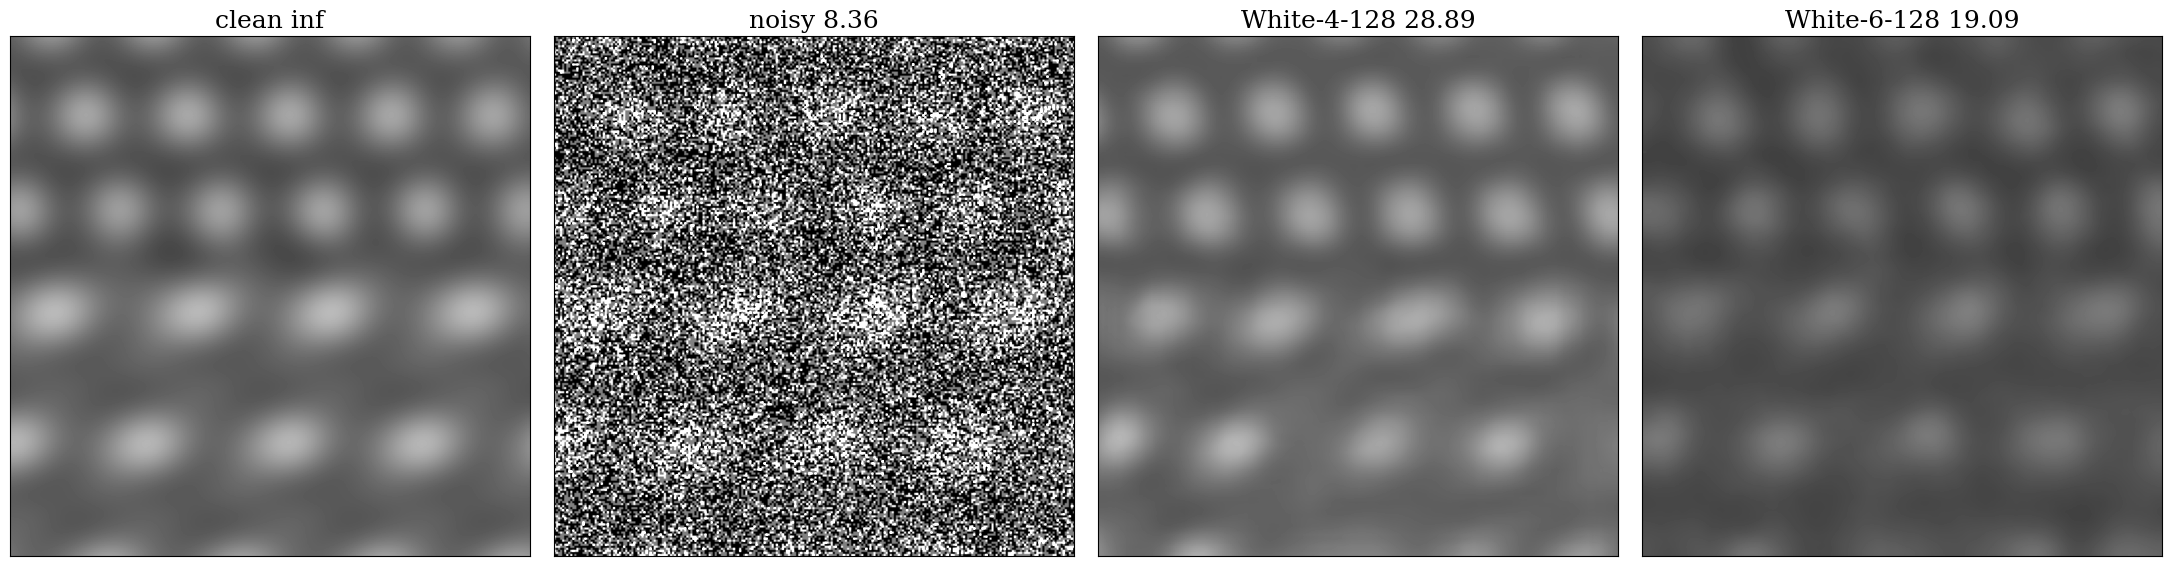

In [ ]:
n = 10
x = test_dataset[n]

clean = x['image'].to(device).unsqueeze(0)
source = clean
# noisy = Poisson(clean).sample()
noisy = source + get_noise(source, noise_scale=noise_scale)
# wavelet_denoised = net(noisy.unsqueeze(0));
# linear_denoised = net_linear(noisy.unsqueeze(0));
#
# source_torch = source.clone().unsqueeze(0)
source = source.cpu().numpy()[0]
# noisy = noisy.numpy()[0]

denoised = {}
with torch.no_grad():
    for key, net in net_dict.items():
        denoised[key] = net(noisy)


visualize_denoising([clean, noisy] + list(denoised.values()),
                            vmax = 1, vmin = 0,
                            labels = ['clean', 'noisy'] + list(denoised.keys()), figsize = (22, 15))

plt.show()

In [ ]:
# net_dict['White-4-128']

## Compare Linear network with Wiener

In [ ]:
import numpy as np
import torch
# path = '/Users/liukangning/Downloads/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'

image_np = np.array(Image.open(path).resize((256,256)))


image_tensor = torch.tensor(image_np).unsqueeze(0)
# clean_tmpt = image_tensor.unsqueeze(0)

In [ ]:
# for data in test_loader:

#     image_tensor = data['image'][0]
#     compare_all(image_tensor,noise_std, wiener_star,wavelets_net_dict[noise_std][2][0],
#                                onelayer_net_dict[noise_std][3], fft_sample = (256, 256))

In [ ]:
noise_scale

2

In [ ]:
# import matplotlib.pyplot as plt

# plt.rcParams['axes.titlesize'] = 16

# def compare_all(source, noise_std, wiener_star, net_linear, unet, figsize=(25, 10), fft_sample=(180, 180),noise_scale=50):
#     noisy = source + get_noise(source, noise_std=noise_std, noise_scale=noise_scale)
# #     wavelet_denoised = net(noisy.unsqueeze(0))
#     linear_denoised = net_linear(noisy.to(device).unsqueeze(0))
#     unet_denoised = unet(noisy.to(device).unsqueeze(0))

#     source_torch = source.clone().unsqueeze(0)
#     source = source.numpy()[0]
#     noisy = noisy.numpy()[0]

#     source_fft = np.fft.fftshift(np.fft.fft2(source, s=fft_sample))
#     noisy_fft = np.fft.fftshift(np.fft.fft2(noisy, s=fft_sample))
#     denoised_fft = noisy_fft * wiener_star

#     source_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(source_fft), s=fft_sample)), 0., 1.)
#     noisy_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(noisy_fft), s=fft_sample)), 0., 1.)
#     denoised_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(denoised_fft), s=fft_sample)), 0., 1.)

#     psnr_noisy = round(compare_psnr(source_ifft, noisy_ifft, data_range=1.), 2)
#     psnr_denoised = round(compare_psnr(source_ifft, denoised_ifft, data_range=1.), 2)
# #     psnr_wavelet = round(batch_PSNR(torch.clamp(wavelet_denoised, 0.0, 1.0), source_torch, 1.), 2)
#     psnr_linear = round(batch_PSNR(torch.clamp(linear_denoised, 0.0, 1.0), source_torch, 1.), 2)
#     psnr_unet = round(batch_PSNR(torch.clamp(unet_denoised, 0.0, 1.0), source_torch, 1.), 2)


#     print( utils.psnr(source_torch, unet_denoised))

#     fig, axes = plt.subplots(2, 5, sharex=True, sharey='row', figsize=figsize)
#     axes[0, 0].imshow(source_ifft, cmap='gray')
#     axes[0, 0].axis('off')
#     plot_2d_log_fft(source_ifft, axes[1, 0])

#     axes[0, 1].imshow(noisy_ifft, cmap='gray')
#     axes[0, 1].set_title(f'noisy image: {psnr_noisy}')
#     axes[0, 1].axis('off')
#     plot_2d_log_fft(noisy_ifft, axes[1, 1])

#     axes[0, 2].imshow(denoised_ifft, cmap='gray')
#     axes[0, 2].set_title(f'wiener_denoised: {psnr_denoised}')
#     axes[0, 2].axis('off')
#     plot_2d_log_fft(denoised_ifft, axes[1, 2])

# #     axes[0, 3].imshow(tensor_to_image(wavelet_denoised), cmap='gray')
# #     axes[0, 3].set_title(f'wavelet_denoised: {psnr_wavelet}')
# #     axes[0, 3].axis('off')
# #     plot_2d_log_fft(tensor_to_image(wavelet_denoised), axes[1, 3])

#     axes[0, 3].imshow(tensor_to_image(linear_denoised), cmap='gray')
#     axes[0, 3].set_title(f'linearnet_denoised: {psnr_linear}')
#     axes[0, 3].axis('off')
#     plot_2d_log_fft(tensor_to_image(linear_denoised), axes[1, 3])

#     axes[0, 4].imshow(tensor_to_image(unet_denoised), cmap='gray')
#     axes[0, 4].set_title(f'DNN_denoised: {psnr_unet}')
#     axes[0, 4].axis('off')
#     plot_2d_log_fft(tensor_to_image(unet_denoised), axes[1, 4])

#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.show()


In [ ]:
import matplotlib.pyplot as plt

# plt.rcParams['axes.titlesize'] = 16

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


def compare_all(source, noise_std, wiener_star, net_linear, unet, figsize=(25, 10), fft_sample=(180, 180),noise_scale=50):
    noisy = source + get_noise(source, noise_std=noise_std, noise_scale=noise_scale)
#     wavelet_denoised = net(noisy.unsqueeze(0))
    linear_denoised = net_linear(noisy.unsqueeze(0))
    unet_denoised = unet(noisy.to(device).unsqueeze(0))

    source_torch = source.clone().unsqueeze(0)
    source = source.numpy()[0]
    noisy = noisy.numpy()[0]

    source_fft = np.fft.fftshift(np.fft.fft2(source, s=fft_sample))
    noisy_fft = np.fft.fftshift(np.fft.fft2(noisy, s=fft_sample))
    denoised_fft = noisy_fft * wiener_star

    source_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(source_fft), s=fft_sample)), 0., 1.)
    noisy_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(noisy_fft), s=fft_sample)), 0., 1.)
    denoised_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(denoised_fft), s=fft_sample)), 0., 1.)

    psnr_noisy = round(compare_psnr(source_ifft, noisy_ifft, data_range=1.), 2)
    psnr_denoised = round(compare_psnr(source_ifft, denoised_ifft, data_range=1.), 2)
#     psnr_wavelet = round(batch_PSNR(torch.clamp(wavelet_denoised, 0.0, 1.0), source_torch, 1.), 2)
    psnr_linear = round(batch_PSNR(torch.clamp(linear_denoised, 0.0, 1.0), source_torch, 1.), 2)
    psnr_unet = round(batch_PSNR(torch.clamp(unet_denoised, 0.0, 1.0), source_torch, 1.), 2)

    fig, axes = plt.subplots(2, 6, sharex=True, sharey='row', figsize=figsize)

    images = [source_ifft, noisy_ifft, denoised_ifft, tensor_to_image(linear_denoised), tensor_to_image(unet_denoised)]
    titles = ["Source", f"Noisy Image: {psnr_noisy}", f"Wiener Denoised: {psnr_denoised}", f"LinearNet Denoised: {psnr_linear}", f"DNN Denoised: {psnr_unet}"]

    # Display images
    for ax, img, title in zip(axes[0,:-1], images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')

    # Display FFT
    for ax, img in zip(axes[1,:-1], images):
        im = plot_2d_log_fft(img, ax)  # Assuming this function returns the image object after imshow
        ax.axis('off')
#         fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Display colorbar

#     # Create a single colorbar in the last column of the second row
#     cbar_ax = axes[1, -1]
#     cbar = fig.colorbar(im, cax=cbar_ax)
#     cbar.set_label('Magnitude (dB)')

#     # Hide axes of the last column in the first row
#     axes[0, -1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    fig.savefig('comparison_plot_microscopy.pdf', bbox_inches='tight', dpi=300)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# plt.rcParams['axes.titlesize'] = 16

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

def save_image(img, filename):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img, aspect='equal', cmap='gray')
    fig.savefig(filename, dpi=300)
    plt.close(fig)



def save_fft(img, filename):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img, aspect='equal', cmap=plt.cm.Blues)
    fig.savefig(filename, dpi=300)
    plt.close(fig)



def compare_all(source, noise_std, wiener_star, net_linear, unet, figsize=(25, 10), fft_sample=(180, 180),noise_scale=50, output_directory="output_images_mc"):
    noisy = source + get_noise(source, noise_std=noise_std, noise_scale=noise_scale)
#     wavelet_denoised = net(noisy.unsqueeze(0))
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)


    linear_denoised = net_linear(noisy.unsqueeze(0))
    unet_denoised = unet(noisy.to(device).unsqueeze(0))

    source_torch = source.clone().unsqueeze(0)
    source = source.numpy()[0]
    noisy = noisy.numpy()[0]

    source_fft = np.fft.fftshift(np.fft.fft2(source, s=fft_sample))
    noisy_fft = np.fft.fftshift(np.fft.fft2(noisy, s=fft_sample))
    denoised_fft = noisy_fft * wiener_star

    source_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(source_fft), s=fft_sample)), 0., 1.)
    noisy_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(noisy_fft), s=fft_sample)), 0., 1.)
    denoised_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(denoised_fft), s=fft_sample)), 0., 1.)

    psnr_noisy = round(compare_psnr(source_ifft, noisy_ifft, data_range=1.), 2)
    psnr_denoised = round(compare_psnr(source_ifft, denoised_ifft, data_range=1.), 2)
#     psnr_wavelet = round(batch_PSNR(torch.clamp(wavelet_denoised, 0.0, 1.0), source_torch, 1.), 2)
    psnr_linear = round(batch_PSNR(torch.clamp(linear_denoised, 0.0, 1.0), source_torch, 1.), 2)
    psnr_unet = round(batch_PSNR(torch.clamp(unet_denoised, 0.0, 1.0), source_torch, 1.), 2)

    fig, axes = plt.subplots(2, 5, sharex=True, sharey='row', figsize=figsize)

    images = [source_ifft, noisy_ifft, denoised_ifft, tensor_to_image(linear_denoised), tensor_to_image(unet_denoised)]
    titles = ["Source", f"Noisy Image: {psnr_noisy}", f"Wiener Denoised: {psnr_denoised}", f"LinearNet Denoised: {psnr_linear}", f"DNN Denoised: {psnr_unet}"]

    # Display images
    for ax, img, title in zip(axes[0,:], images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
        filename = os.path.join(output_directory, title.replace(" ", "_").replace(":", "") + ".pdf")
        save_image(img, filename)




    # Display the FFTs of the images
    min_values, max_values = [], []
    for ax, image, title in zip(axes[1, :], images,titles):
        fft_display = plot_2d_log_fft(image, ax)  # Assuming this function displays the FFT and returns the image object
#         print(fft_display.get_array().min())
#         print(fft_display.get_array().max())
#         print(type(fft_display))
        min_values.append(fft_display.get_array().min())
        max_values.append(fft_display.get_array().max())
        ax.axis('off')
        filename = os.path.join(output_directory, title.replace(" ", "_").replace(":", "") + "_FFT.pdf")
        print(fft_display.get_array().data.shape)
        save_fft(fft_display.get_array().data,filename)



    # Display colorbar in the 6th column
    min_value, max_value = np.min(min_values), np.max(max_values)
    norm = plt.Normalize(vmin=min_value, vmax=max_value)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=np.min(min_values), vmax=np.max(max_values)))
    colorbar_axes = fig.add_axes([0.83, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    colorbar = fig.colorbar(sm, cax=colorbar_axes, orientation='vertical', format='%.1f')
    colorbar.set_label('Magnitude (dB)')
    colorbar.set_ticks(np.linspace(min_value, max_value, num=10))
#     fig.colorbar(sm, ax=axes[:, -1], orientation='vertical', format='%.1f', aspect=40)
#     axes[0, -1].set_title('Magnitude (dB)')

    fig, ax = plt.subplots(figsize=(2, 4))  # Adjust the width in figsize to make the entire figure wider

    # Remove the axis and figure border
    ax.axis('off')
    for spine in ax.spines.values():
        spine.set_visible(False)

    norm = plt.Normalize(vmin=np.min(min_values), vmax=np.max(max_values))
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)

    # Define a position and size for the colorbar within the figure
    cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.7])  # [left, bottom, width, height]

    fig.colorbar(sm, cax=cbar_ax, orientation='vertical', format='%.1f')
    cbar_ax.set_title('Magnitude (dB)')
    fig.tight_layout()
    fig.savefig(os.path.join(output_directory, 'colorbar.pdf'), bbox_inches='tight', dpi=300)
    plt.close(fig)



    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    fig.savefig('comparison_plot_microscopy.pdf', bbox_inches='tight', dpi=300)


In [ ]:
noise_scale

2

In [ ]:
noise_scale

2

In [ ]:
len(test_loader.dataset)

22

In [ ]:
from torch.distributions import Poisson
import matplotlib.pyplot as plt
# Assume tensor_to_image, plot_2d_log_fft, and batch_PSNR are defined elsewhere

def visualize_denoising(source, net, noise_sample=None, noise_scale=1.0, figsize=(20, 20)):
    fig, axes = plt.subplots(2, 3, sharex=True, sharey='row', figsize=figsize)

    axes[0, 0].imshow(tensor_to_image(source), cmap='gray')
    axes[0, 0].axis('off')
    plot_2d_log_fft(tensor_to_image(source), axes[1, 0])

    print(source[0, 0].size())

#     if noise_sample is None:
#         # Scale the source tensor to control the noise level
#         scaled_source = source * noise_scale
#         # Generate Poisson noise sample based on the scaled source
#         noise_sample = Poisson(scaled_source).sample()
#         # Scale back the generated noise
#         noise_sample = (noise_sample - scaled_source) / noise_scale



#     noisy = source + noise_sample
    if noise_sample is None:
        noisy  = source + get_noise(source, noise_scale = noise_scale)

    axes[0, 1].imshow(tensor_to_image(noisy), cmap='gray')
    axes[0, 1].axis('off')
    axes[0, 1].set_title(str(batch_PSNR(noisy, source, 1.0)))
    plot_2d_log_fft(tensor_to_image(noisy), axes[1, 1])
    with torch.no_grad():
      denoised = net(noisy)

    axes[0, 2].imshow(tensor_to_image(denoised), cmap='gray')
    axes[0, 2].axis('off')
    axes[0, 2].set_title(str(batch_PSNR(torch.clamp(denoised, 0.0, 1.0), source, 1.0)))
    plot_2d_log_fft(tensor_to_image(denoised), axes[1, 2])

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


torch.Size([876, 927])


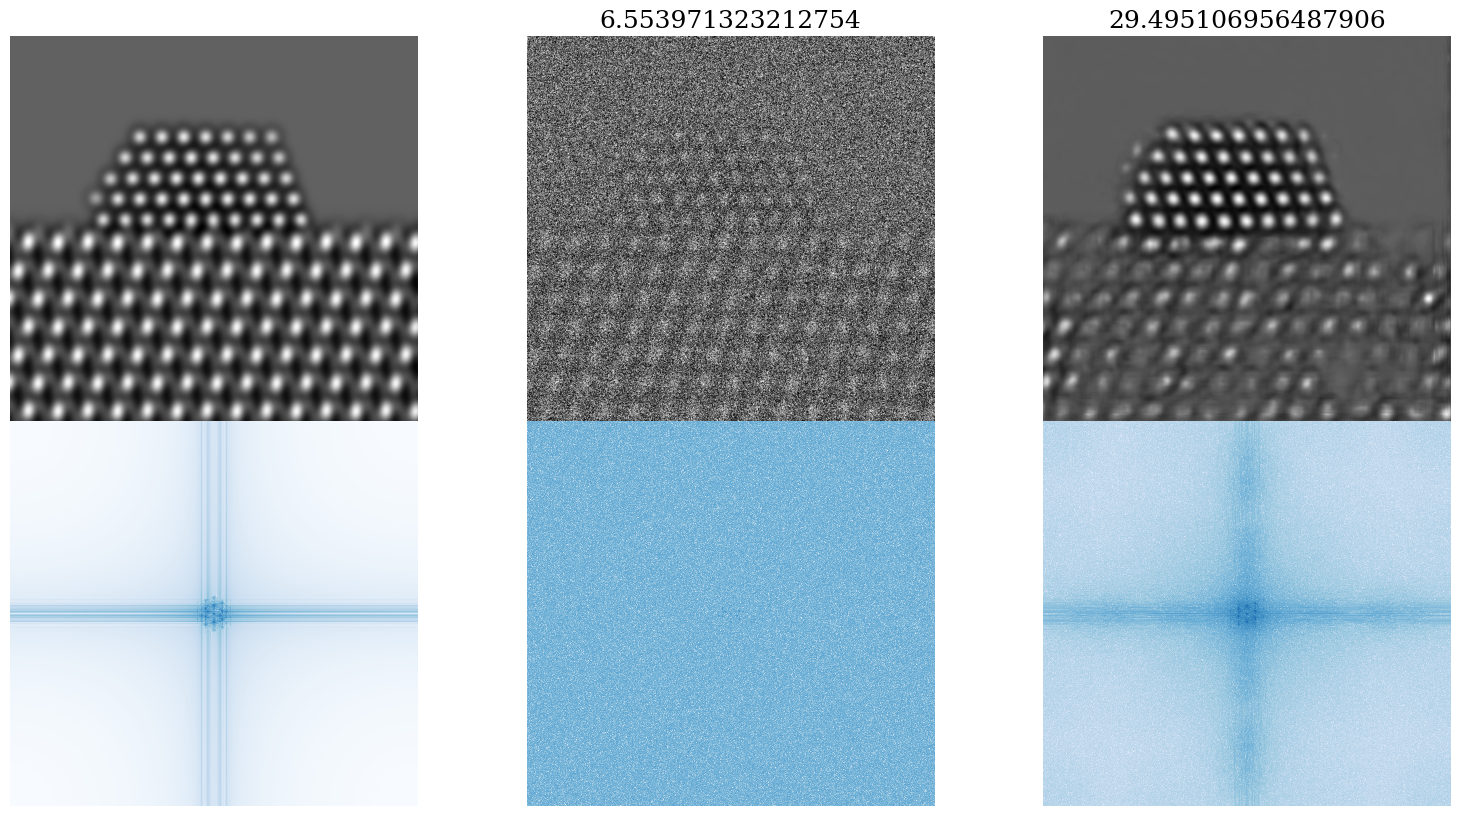

In [ ]:
visualize_denoising(image_tensor[:,:,:,:].to(device), net_dict['White-4-128'], figsize=(20, 10),noise_scale=2)

In [ ]:
noise_scale

2

## compare with unsupervised models

In [ ]:
def load_model_multi(checkpoint_path):
    checkpoint_path_model =  '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/checkpoints/unet-128-small.pt'
    state_dict = torch.load( checkpoint_path_model, map_location=lambda s,
                                l: default_restore_location(s,"cpu"))


    args = argparse.Namespace(
        **{**vars(state_dict["args"])})
    model = models_microscopy.build_model(args).to(device)

    mode_statdict = torch.load( checkpoint_path, map_location=lambda s,
                                l: default_restore_location(s,"cpu"))

    model.load_state_dict(mode_statdict)
    model.eval()
    return model

diff_checkpoint_path = {
    # 'White-4-128': '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/checkpoints/unet-128-small.pt',
    # 'White-6-128': '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/checkpoints/unet-128-big.pt',
    'noise2noise': '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/image_wavelet/microscopy_noise2noise2.pt',
    'neighbor2neighbor2': '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/image_wavelet/microscopy_neighbor2neighbor2.pt',
}
net_dict = {}
for key, checkpoint_path in diff_checkpoint_path.items():
    net_dict[key] = load_model_multi(checkpoint_path).to(device)
    print(f" {key} with parameters {sum(p.numel() for p in net_dict[key].parameters()):,}")
net_dict['White-4-128'] = load_model('/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/checkpoints/unet-128-small.pt').to(device)

 noise2noise with parameters 5,613,441
 neighbor2neighbor2 with parameters 5,613,441


torch.Size([1, 1, 876, 927])
Possion Distribution
torch.Size([256, 256])


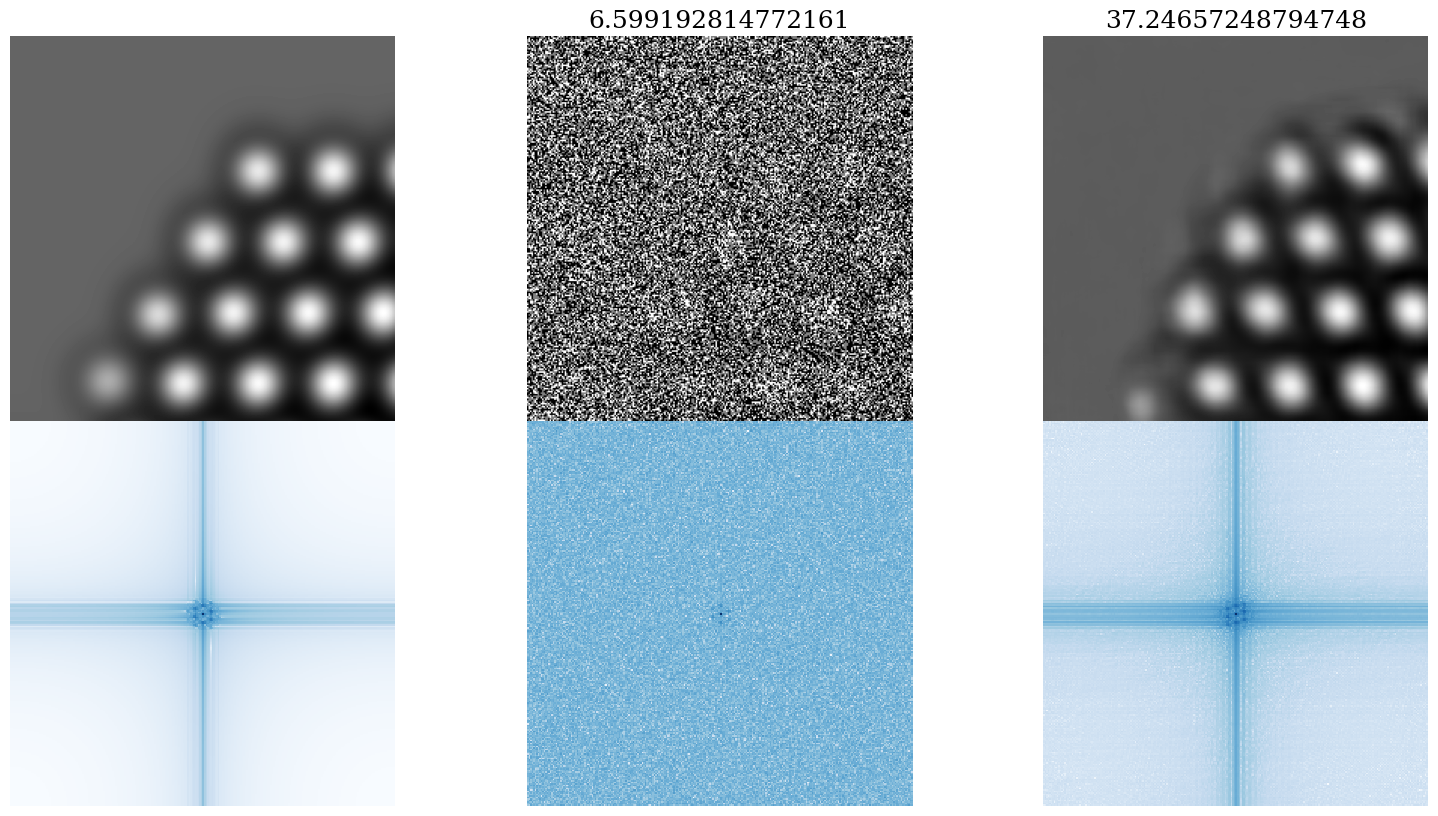

In [ ]:
import numpy as np
from PIL import Image
import torch
path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
# image_np = np.array(Image.open(path).resize((256,256)))
image_np = np.array(Image.open(path))


image_tensor = torch.tensor(image_np).unsqueeze(0).unsqueeze(0)
print(image_tensor.size())
# clean_tmpt = image_tensor.unsqueeze(0)

# for noise_std in noise_std_array:
#     print('='*50 +'\n\n')
print('Possion Distribution')
visualize_denoising(image_tensor[:,:,140:396,130:386].to(device), net_dict['White-4-128'], figsize=(20, 10),noise_scale=2)
    # visualize_best_wiener_denoising(image_tensor, noise_std, wiener_star[noise_std], fft_sample=(image_np.shape[0], image_np.shape[1]))

In [ ]:
import numpy as np
from PIL import Image
import torch
# path = '/Users/liukangning/Downloads/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
# image_np = np.array(Image.open(path).resize((256,256)))
image_np = np.array(Image.open(path))
image_np = center_crop(image_np, output_size=(256,256))



image_tensor = torch.tensor(image_np).unsqueeze(0)
clean_tmpt = image_tensor.unsqueeze(0)

# for noise_std in noise_std_array:
#     print('='*50 +'\n\n')
#     print('Noise Std: ', noise_std)

visualize_best_wiener_denoising(image_tensor, wiener_star, fft_sample=(image_np.shape[0], image_np.shape[1]), noise_scale=noise_scale)

In [ ]:
from torch.distributions import Poisson
import matplotlib.pyplot as plt
import torch
# Assume tensor_to_image, plot_2d_log_fft, and batch_PSNR are defined elsewhere

def visualize_and_save_denoising_individual(source, net, noise_sample=None, noise_scale=1.0, figsize=(10, 10), save_dir='images/', dpi=300):
    """
    Visualizes and saves individual figures for each step in the denoising process without titles,
    with high DPI and tight layout, including the PSNR value in the filename.

    Args:
        source (Tensor): The source image tensor.
        net (nn.Module): The neural network used for denoising.
        noise_sample (Tensor, optional): Sample noise to add to the source. Defaults to None.
        noise_scale (float, optional): The scale of noise. Defaults to 1.0.
        figsize (tuple, optional): Figure size for the plots. Defaults to (10, 10).
        save_dir (str, optional): Directory to save the images. Defaults to 'images/'.
        dpi (int, optional): Dots per inch for saved images. Defaults to 300.

    Returns:
        None
    """

    # Original Image
    plt.figure(figsize=figsize)
    original_image = tensor_to_image(source)
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')
    plt.savefig(f'{save_dir}original_image.png', dpi=dpi, bbox_inches='tight')

    # Original Image - Fourier Transform
    plt.figure(figsize=figsize)
    plot_2d_log_fft(original_image, plt.gca())
    plt.savefig(f'{save_dir}original_image_fft.png', dpi=dpi, bbox_inches='tight')

    # Noisy Image
    if noise_sample is None:
        noisy = source + get_noise(source, noise_scale=noise_scale)
    else:
        noisy = source + noise_sample
    noisy_image = tensor_to_image(noisy)
    psnr_noisy = batch_PSNR(noisy, source, 1.0)
    plt.figure(figsize=figsize)
    plt.imshow(noisy_image, cmap='gray')
    plt.axis('off')
    plt.savefig(f'{save_dir}noisy_image_PSNR_{psnr_noisy:.2f}.png', dpi=dpi, bbox_inches='tight')

    # Noisy Image - Fourier Transform
    plt.figure(figsize=figsize)
    plot_2d_log_fft(noisy_image, plt.gca())
    plt.savefig(f'{save_dir}noisy_image_fft_PSNR_{psnr_noisy:.2f}.png', dpi=dpi, bbox_inches='tight')

    # Denoised Image
    with torch.no_grad():
        denoised = net(noisy)
    denoised_image = tensor_to_image(torch.clamp(denoised, 0.0, 1.0))
    psnr_denoised = batch_PSNR(torch.clamp(denoised, 0.0, 1.0), source, 1.0)
    plt.figure(figsize=figsize)
    plt.imshow(denoised_image, cmap='gray')
    plt.axis('off')
    plt.savefig(f'{save_dir}denoised_image_PSNR_{psnr_denoised:.2f}.png', dpi=dpi, bbox_inches='tight')

    # Denoised Image - Fourier Transform
    plt.figure(figsize=figsize)
    plot_2d_log_fft(denoised_image, plt.gca())
    plt.savefig(f'{save_dir}denoised_image_fft_PSNR_{psnr_denoised:.2f}.png', dpi=dpi, bbox_inches='tight')


In [ ]:
! mkdir '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/results_compare/'

mkdir: cannot create directory ‘/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/results_compare/’: File exists


torch.Size([1, 1, 876, 927])
Possion Distribution


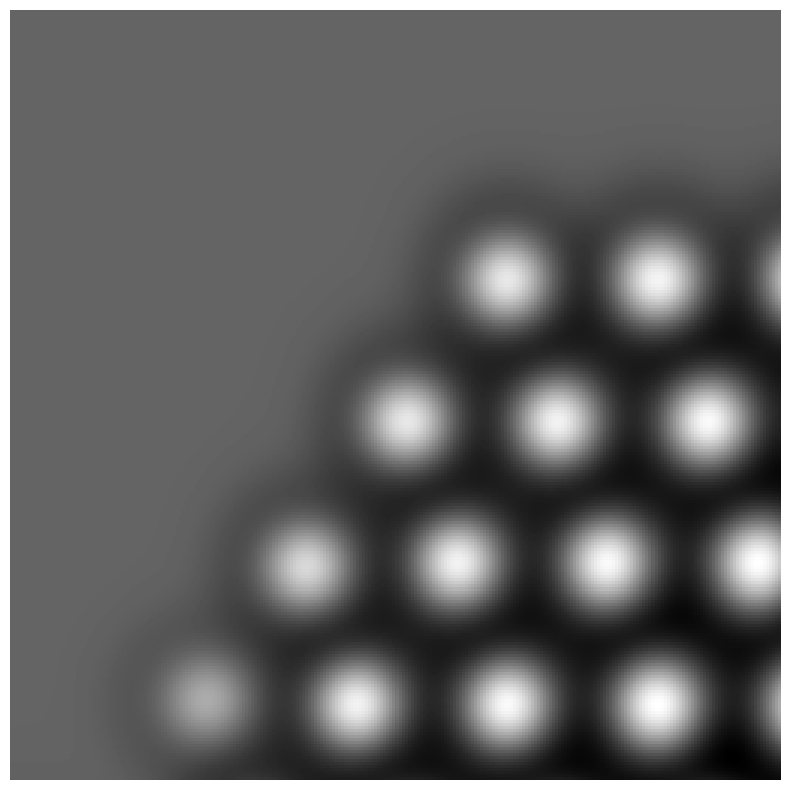

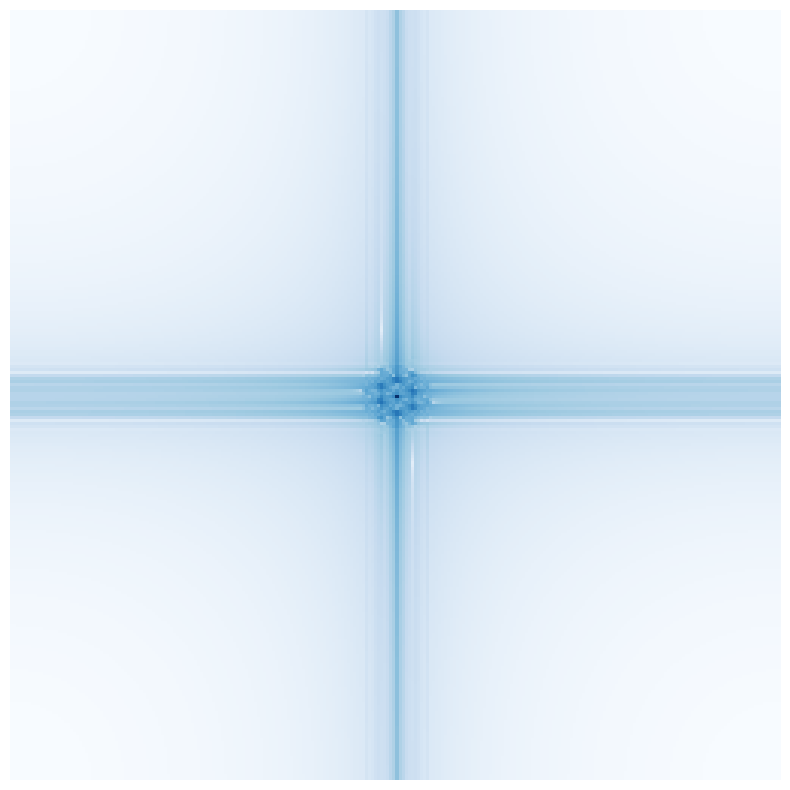

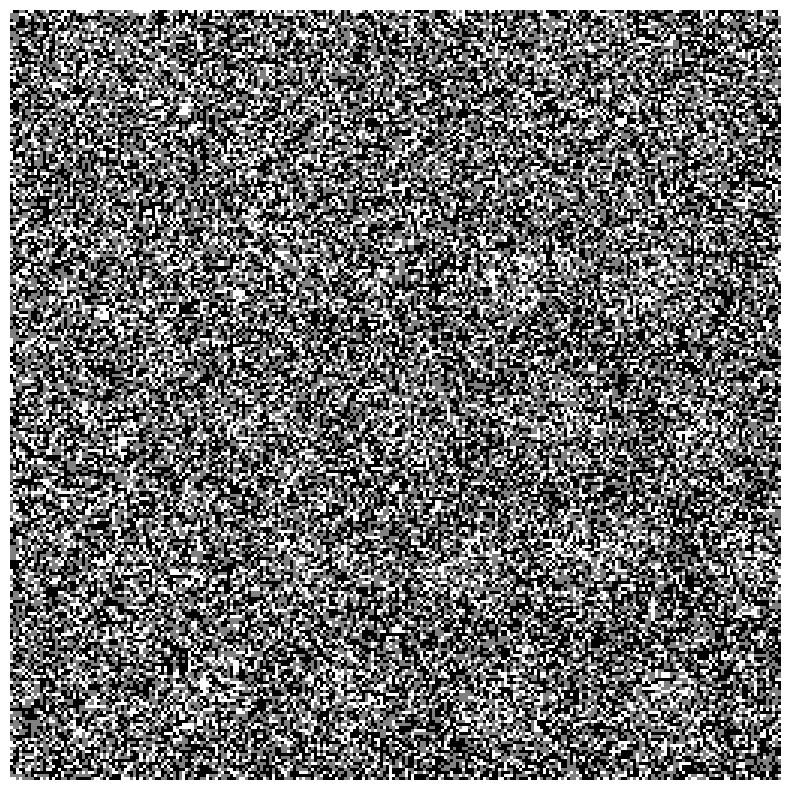

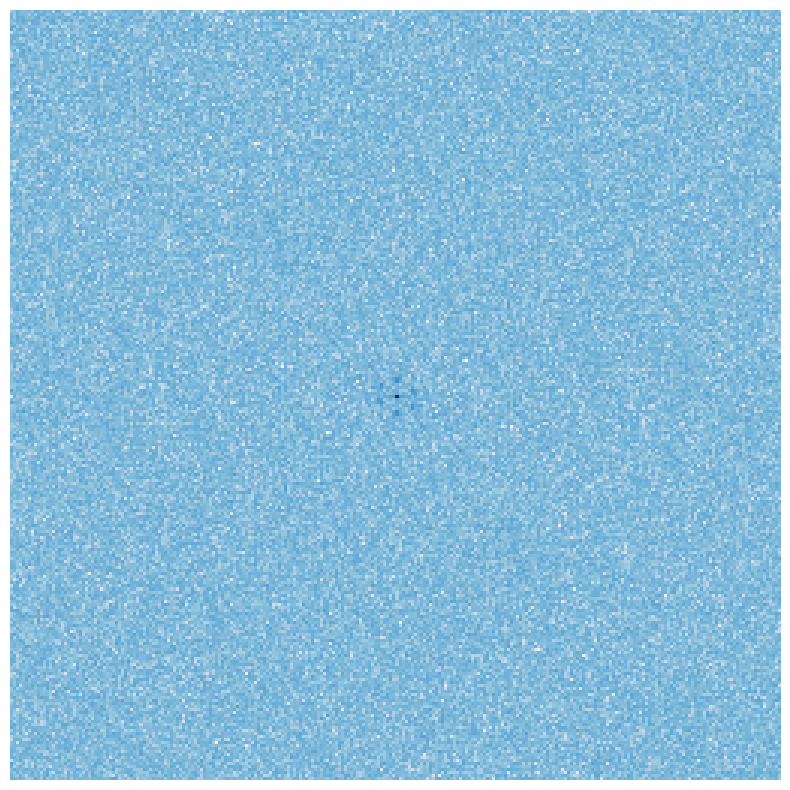

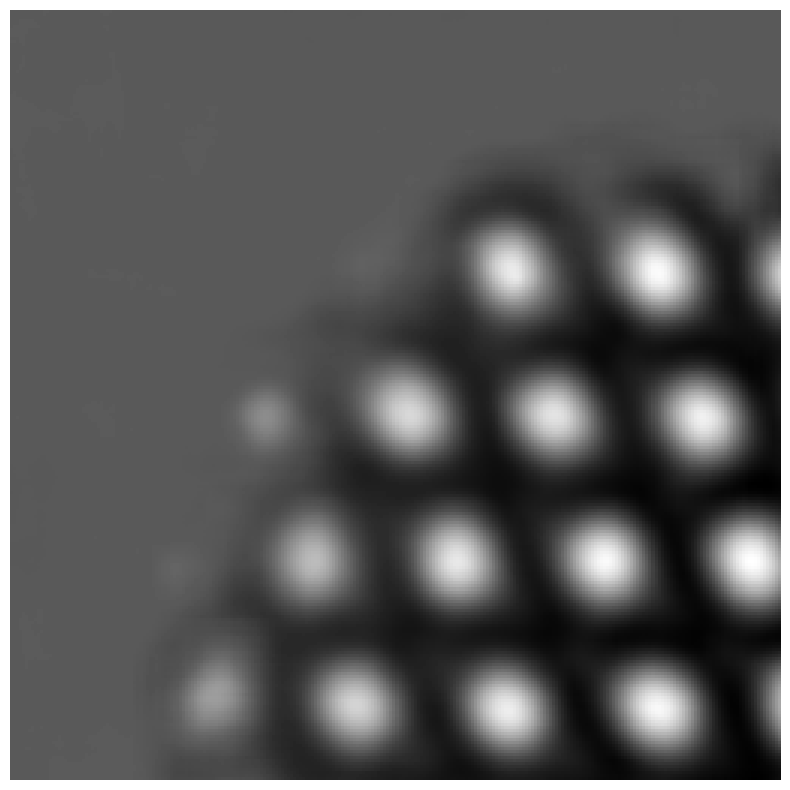

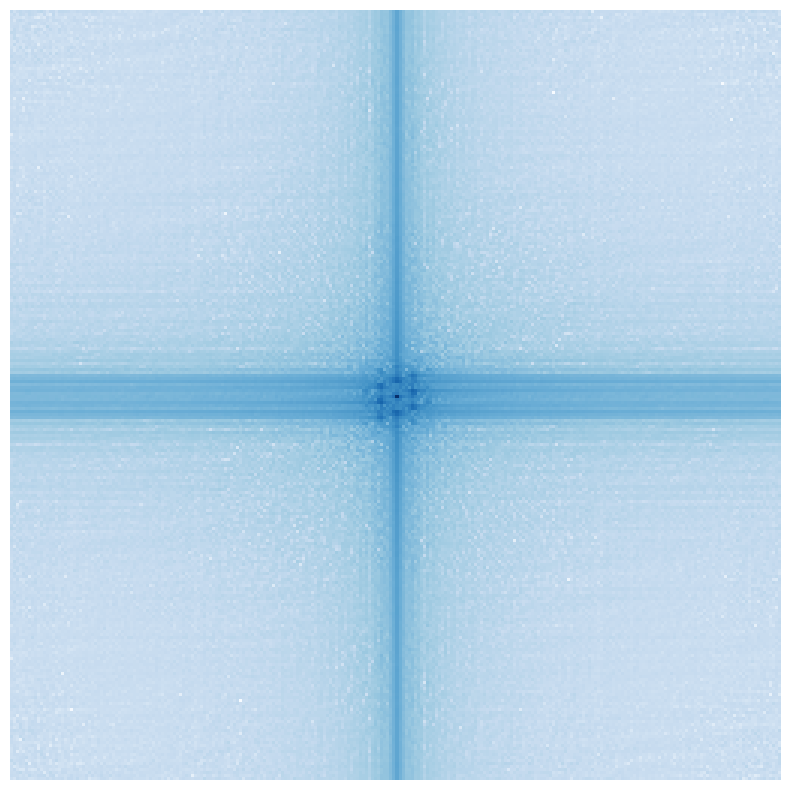

In [ ]:
import numpy as np
from PIL import Image
import torch
path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
# image_np = np.array(Image.open(path).resize((256,256)))
image_np = np.array(Image.open(path))

save_dir = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/results_compare/supervised/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
image_tensor = torch.tensor(image_np).unsqueeze(0).unsqueeze(0)
print(image_tensor.size())
# clean_tmpt = image_tensor.unsqueeze(0)

# for noise_std in noise_std_array:
#     print('='*50 +'\n\n')
print('Possion Distribution')
visualize_and_save_denoising_individual(image_tensor[:,:,140:396,130:386].to(device), net_dict['White-4-128'], figsize=(20, 10),noise_scale=2, save_dir=save_dir)
    # visualize_best_wiener_denoising(image_tensor, noise_std, wiener_star[noise_std], fft_sample=(image_np.shape[0], image_np.shape[1]))

torch.Size([1, 1, 876, 927])
Possion Distribution


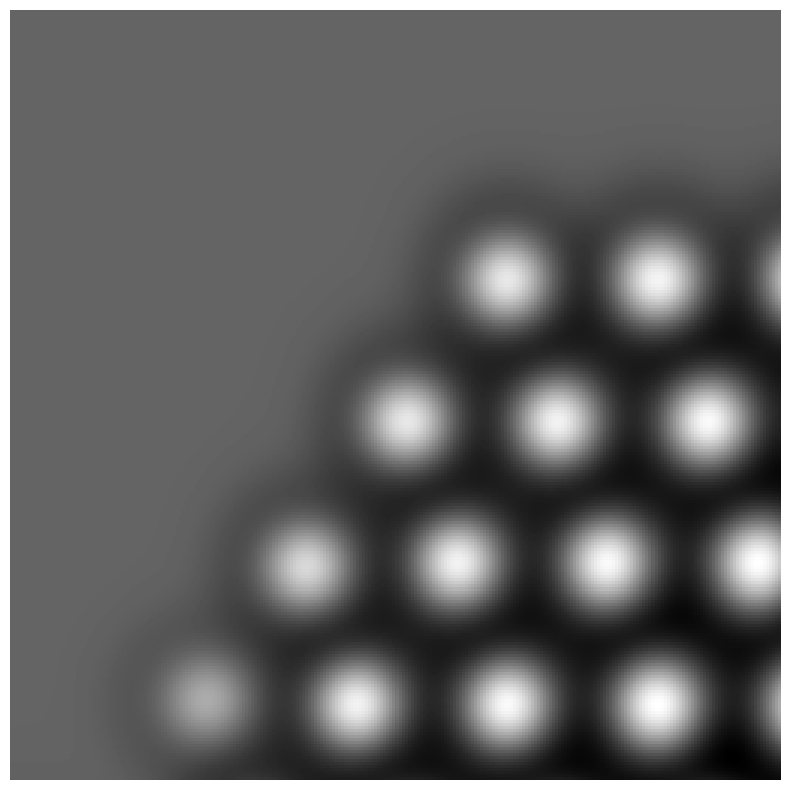

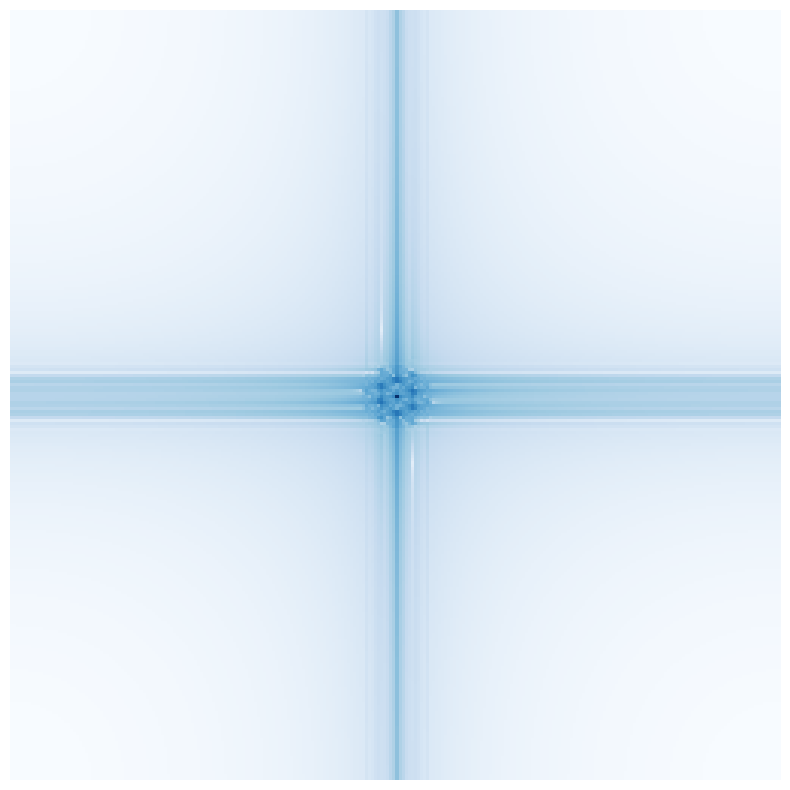

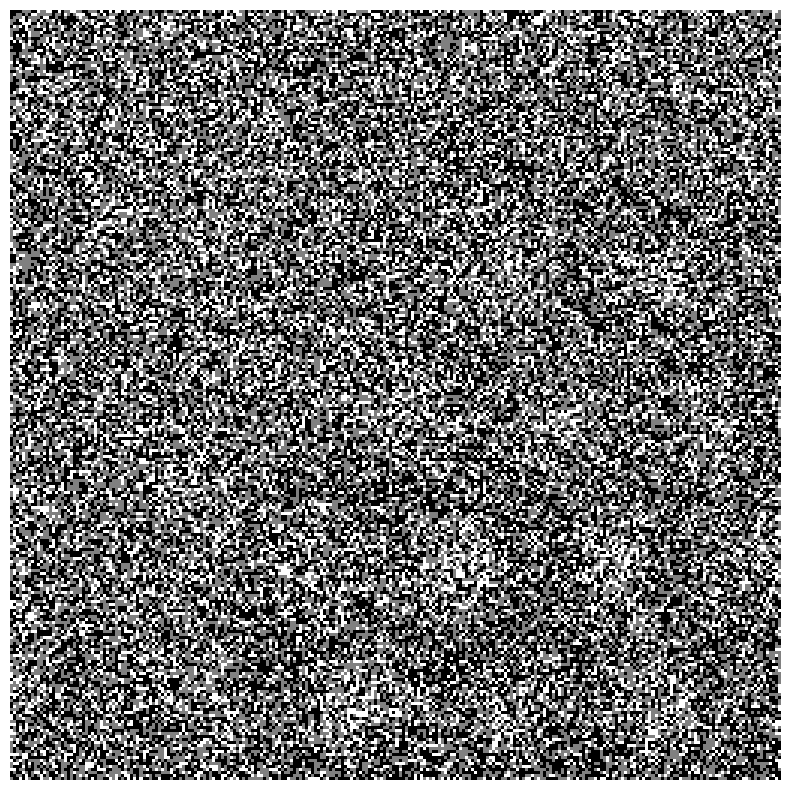

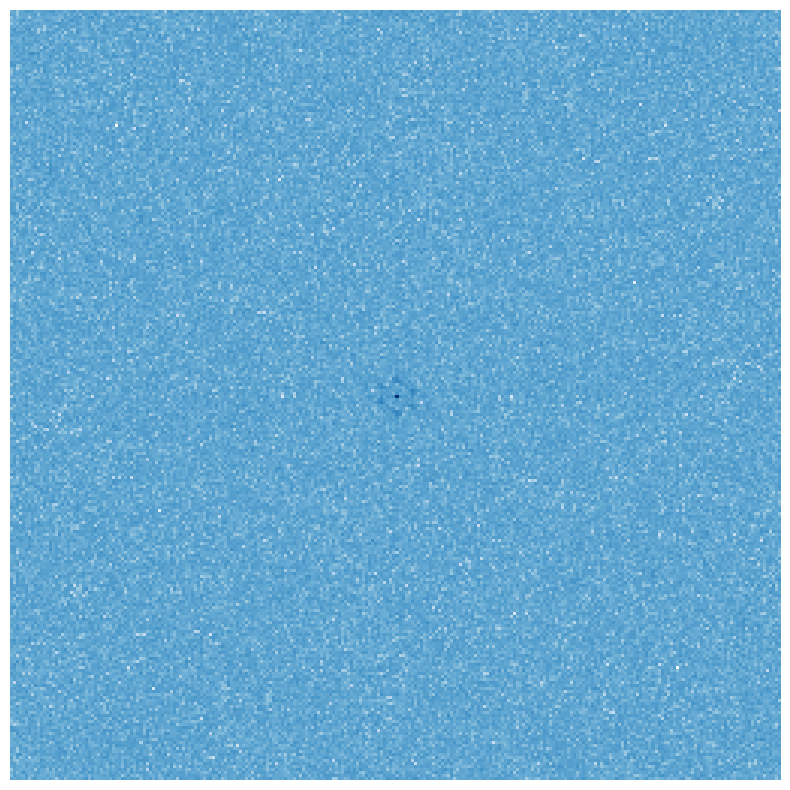

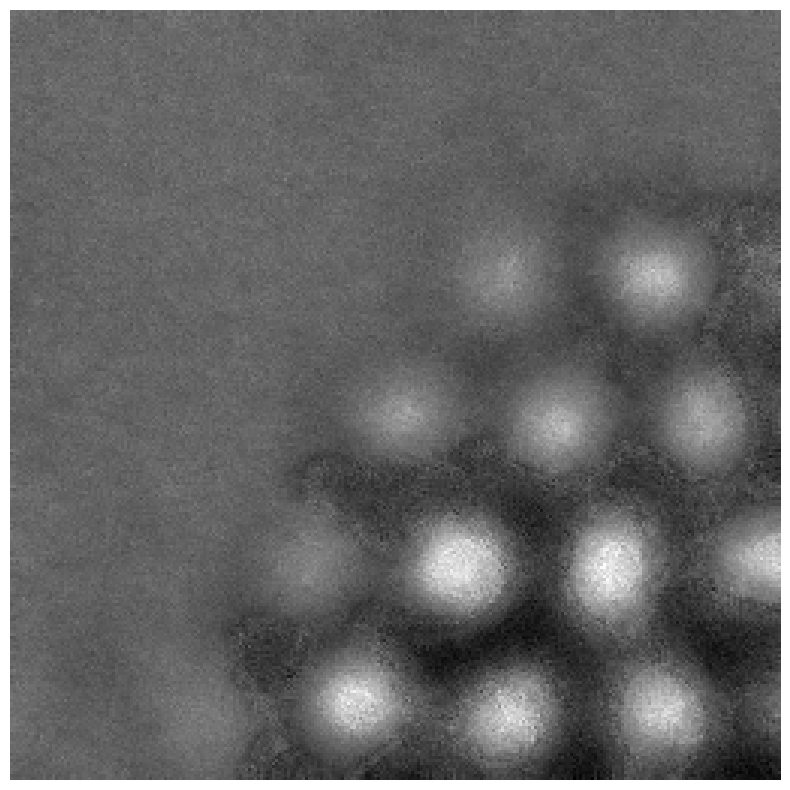

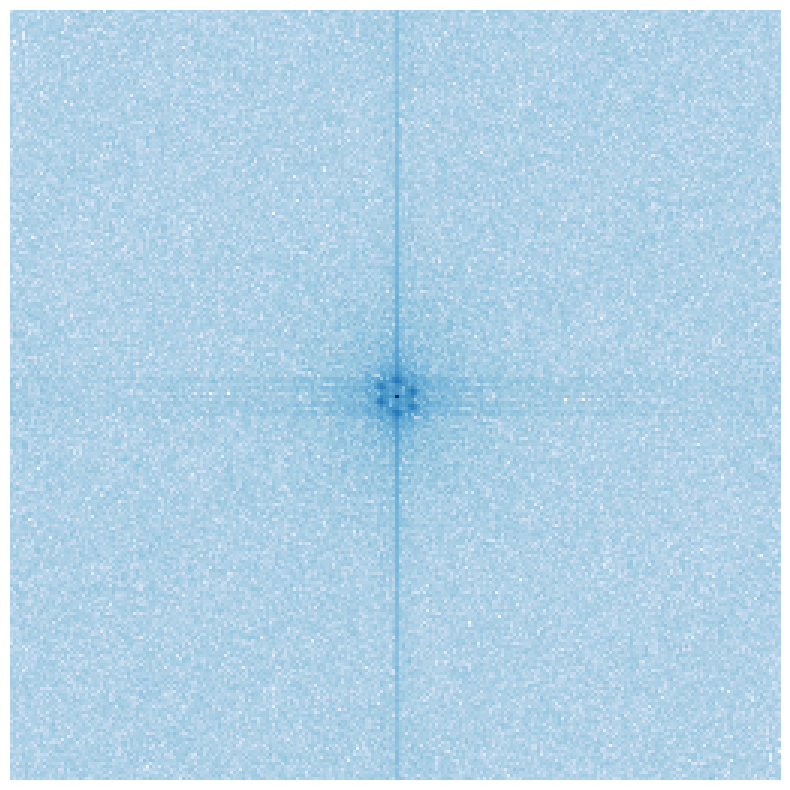

In [ ]:
import numpy as np
from PIL import Image
import torch
path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
# image_np = np.array(Image.open(path).resize((256,256)))
image_np = np.array(Image.open(path))

save_dir = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/results_compare/noise2noise/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
image_tensor = torch.tensor(image_np).unsqueeze(0).unsqueeze(0)
print(image_tensor.size())
# clean_tmpt = image_tensor.unsqueeze(0)

# for noise_std in noise_std_array:
#     print('='*50 +'\n\n')
print('Possion Distribution')
visualize_and_save_denoising_individual(image_tensor[:,:,140:396,130:386].to(device), net_dict['noise2noise'], figsize=(20, 10),noise_scale=2, save_dir=save_dir)
    # visualize_best_wiener_denoising(image_tensor, noise_std, wiener_star[noise_std], fft_sample=(image_np.shape[0], image_np.shape[1]))

torch.Size([1, 1, 876, 927])
Possion Distribution


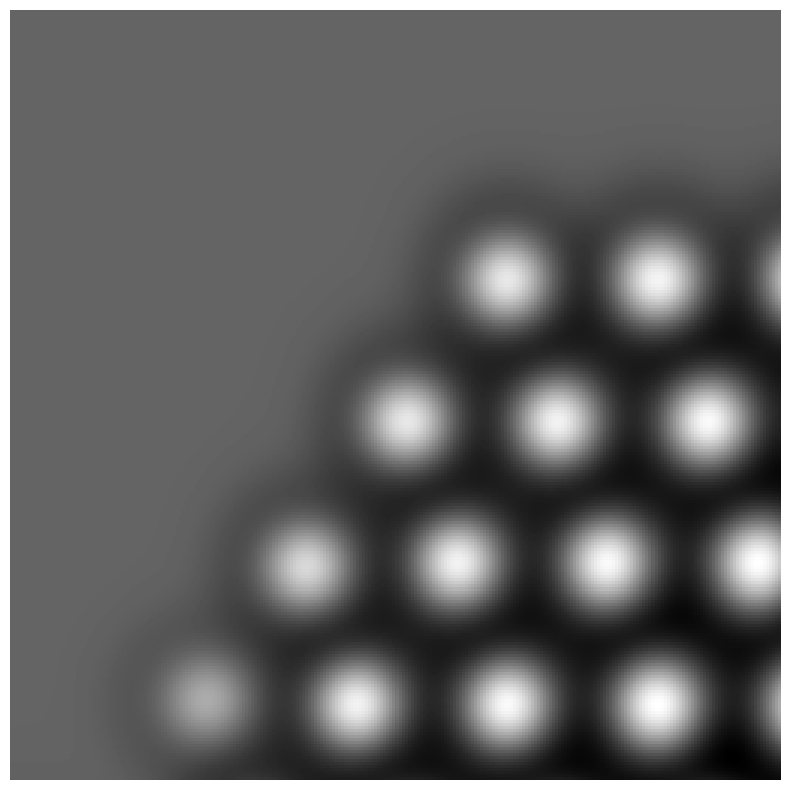

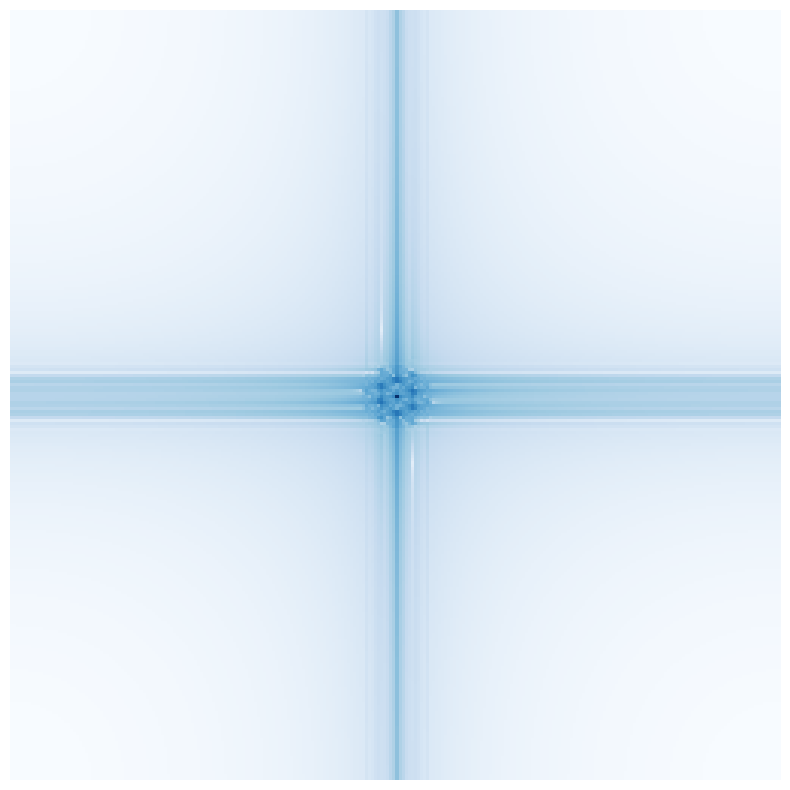

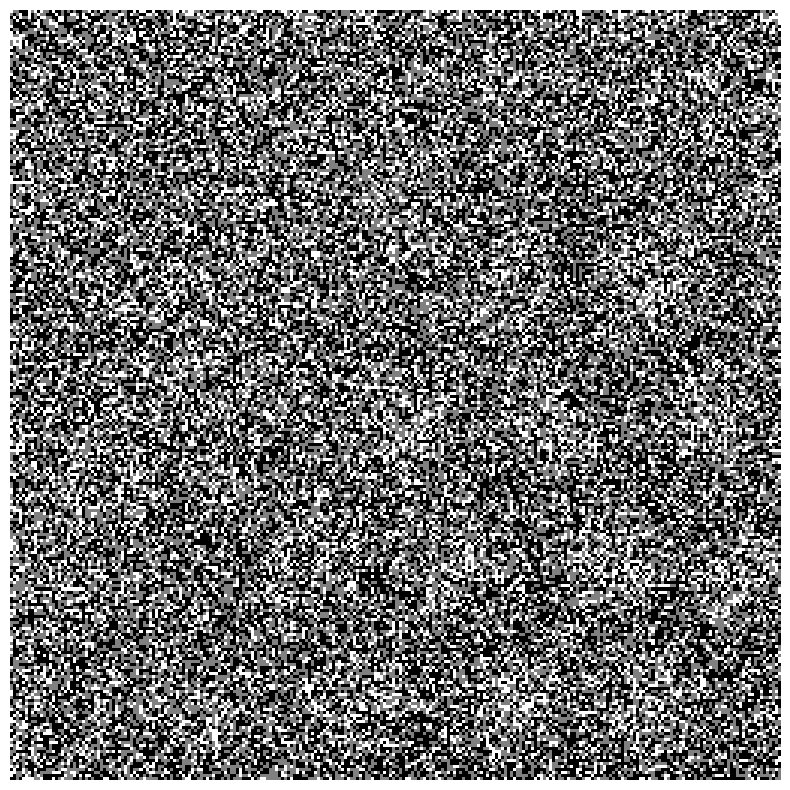

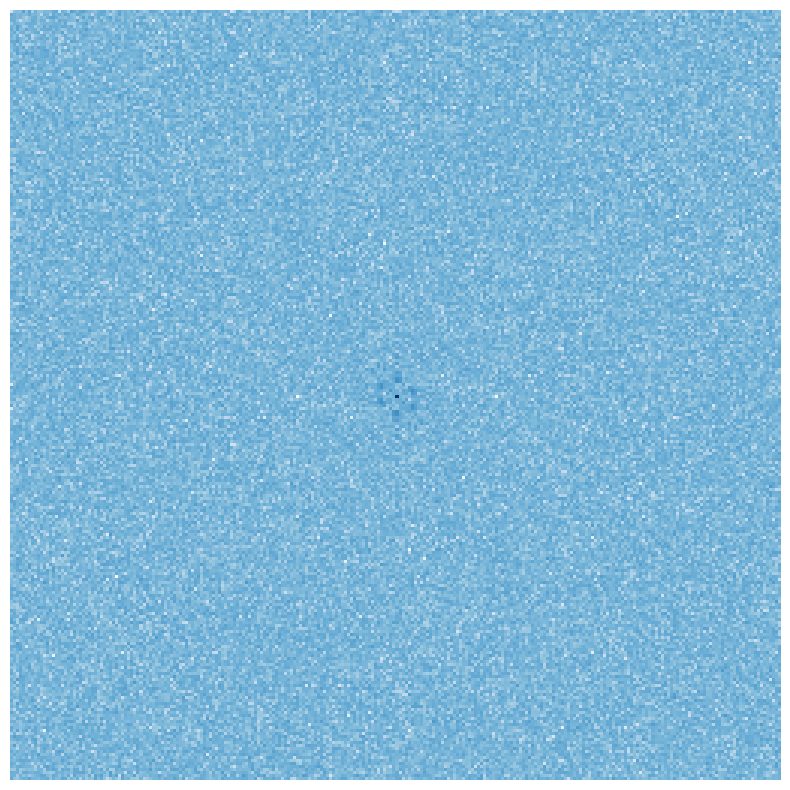

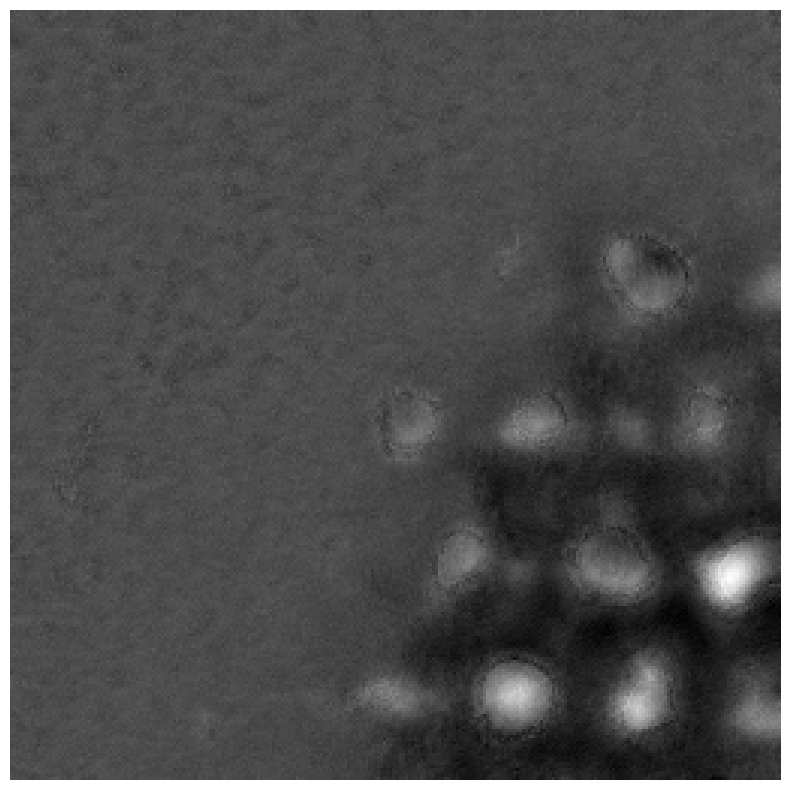

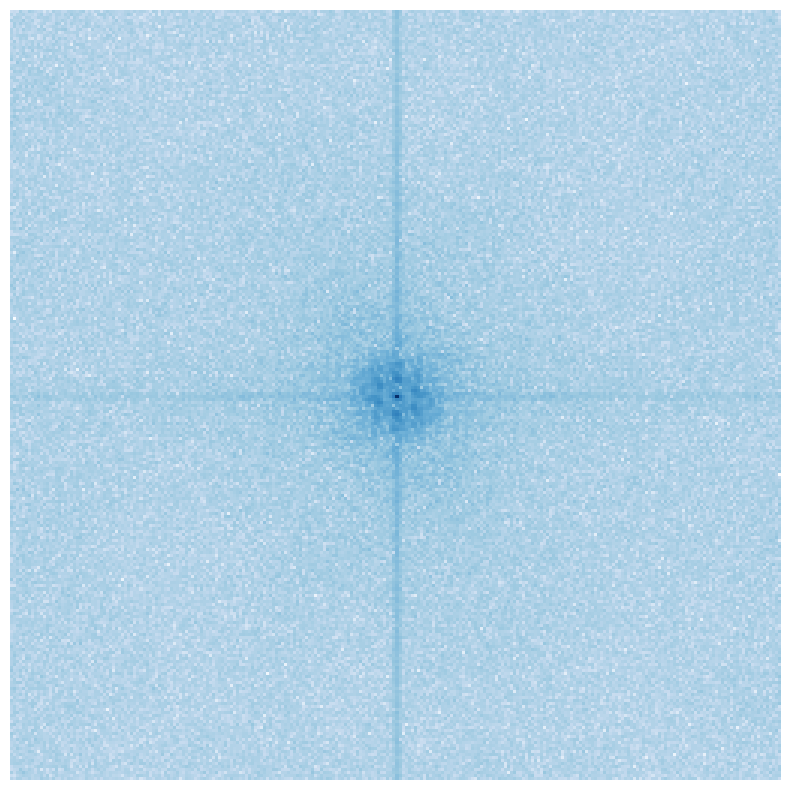

In [ ]:
import numpy as np
from PIL import Image
import torch
path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
# image_np = np.array(Image.open(path).resize((256,256)))
image_np = np.array(Image.open(path))

save_dir = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/results_compare/neighbor2neighbor2/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
image_tensor = torch.tensor(image_np).unsqueeze(0).unsqueeze(0)
print(image_tensor.size())
# clean_tmpt = image_tensor.unsqueeze(0)

# for noise_std in noise_std_array:
#     print('='*50 +'\n\n')
print('Possion Distribution')
visualize_and_save_denoising_individual(image_tensor[:,:,140:396,130:386].to(device), net_dict['neighbor2neighbor2'], figsize=(20, 10),noise_scale=2, save_dir=save_dir)
    # visualize_best_wiener_denoising(image_tensor, noise_std, wiener_star[noise_std], fft_sample=(image_np.shape[0], image_np.shape[1]))

## save wiener

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Poisson
# Assume tensor_to_image, get_noise, plot_2d_log_fft, and compare_psnr are defined elsewhere

def visualize_best_wiener_denoising_save(source, wiener_star, figsize=(20, 10), fft_sample=(256, 256), noise_scale=1, save_dir='images/', dpi=300):
    """
    Visualizes and saves individual plots for source, noisy, and denoised images along with their FFTs,
    including the PSNR value in the filename.

    Args:
        source (Tensor): The source image tensor.
        wiener_star (Tensor): The Wiener filter tensor.
        figsize (tuple, optional): Figure size for the plots. Defaults to (20, 10).
        fft_sample (tuple, optional): FFT sample size. Defaults to (256, 256).
        noise_scale (float, optional): The scale of noise. Defaults to 1.
        save_dir (str, optional): Directory to save the images. Defaults to 'images/'.
        dpi (int, optional): Dots per inch for saved images. Defaults to 300.

    Returns:
        None
    """

    noisy = source + get_noise(source, mode='poisson', noise_scale=noise_scale)
    noisy = noisy.numpy()[0]
    source = source.numpy()[0]

    # FFT and IFFT operations
    source_fft = np.fft.fftshift(np.fft.fft2(source, s=fft_sample))
    noisy_fft = np.fft.fftshift(np.fft.fft2(noisy, s=fft_sample))
    denoised_fft = noisy_fft * wiener_star

    source_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(source_fft), s=fft_sample)), 0., 1.)
    noisy_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(noisy_fft), s=fft_sample)), 0., 1.)
    denoised_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(denoised_fft), s=fft_sample)), 0., 1.)

    # PSNR calculations
    psnr_noisy = compare_psnr(source_ifft, noisy_ifft, data_range=1.)
    psnr_denoised = compare_psnr(source_ifft, denoised_ifft, data_range=1.)

    # Source Image and FFT
    plt.figure(figsize=figsize)
    plt.imshow(source_ifft, cmap='gray')
    plt.axis('off')
    plt.savefig(f'{save_dir}source_image.png', dpi=dpi, bbox_inches='tight')

    plt.figure(figsize=figsize)
    plot_2d_log_fft(source_ifft, plt.gca())
    plt.savefig(f'{save_dir}source_fft.png', dpi=dpi, bbox_inches='tight')

    # Noisy Image and FFT
    plt.figure(figsize=figsize)
    plt.imshow(noisy_ifft, cmap='gray')
    plt.axis('off')
    plt.savefig(f'{save_dir}noisy_image_PSNR_{psnr_noisy:.2f}.png', dpi=dpi, bbox_inches='tight')

    plt.figure(figsize=figsize)
    plot_2d_log_fft(noisy_ifft, plt.gca())
    plt.savefig(f'{save_dir}noisy_fft_PSNR_{psnr_noisy:.2f}.png', dpi=dpi, bbox_inches='tight')

    # Denoised Image and FFT
    plt.figure(figsize=figsize)
    plt.imshow(denoised_ifft, cmap='gray')
    plt.axis('off')
    plt.savefig(f'{save_dir}denoised_image_PSNR_{psnr_denoised:.2f}.png', dpi=dpi, bbox_inches='tight')

    plt.figure(figsize=figsize)
    plot_2d_log_fft(denoised_ifft, plt.gca())
    plt.savefig(f'{save_dir}denoised_fft_PSNR_{psnr_denoised:.2f}.png', dpi=dpi, bbox_inches='tight')


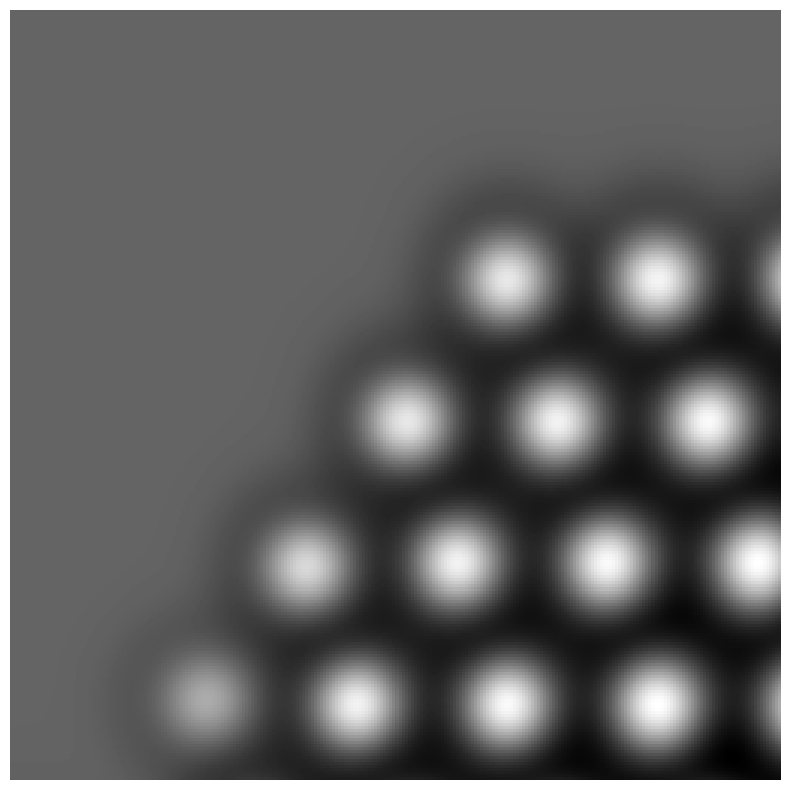

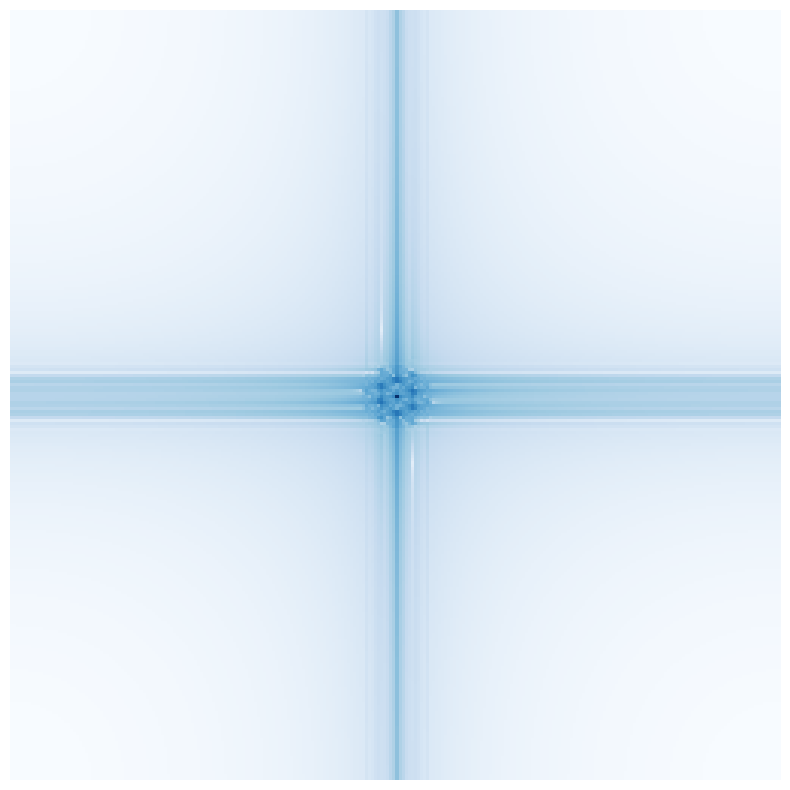

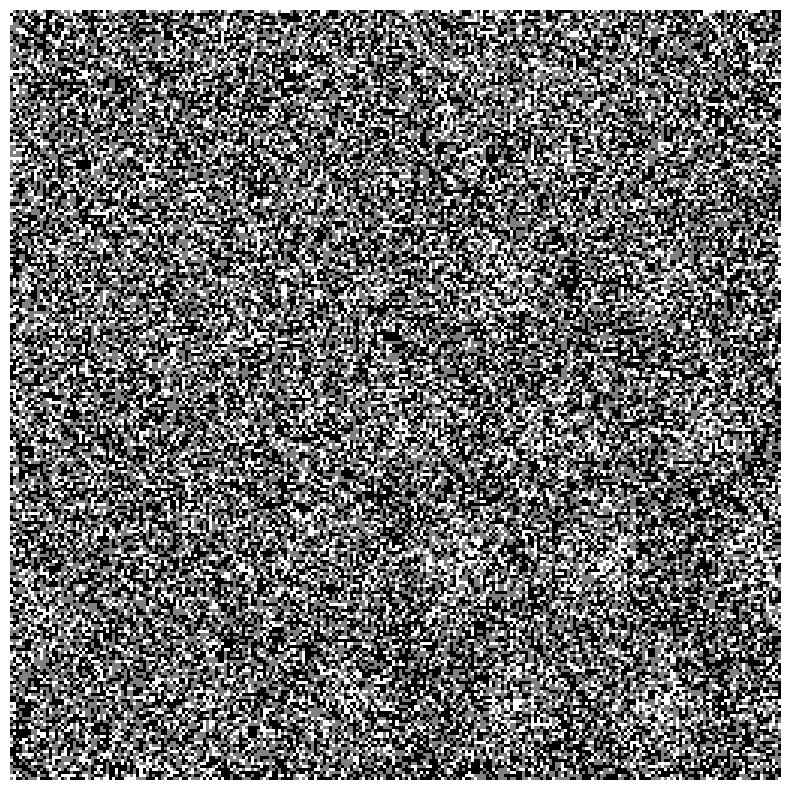

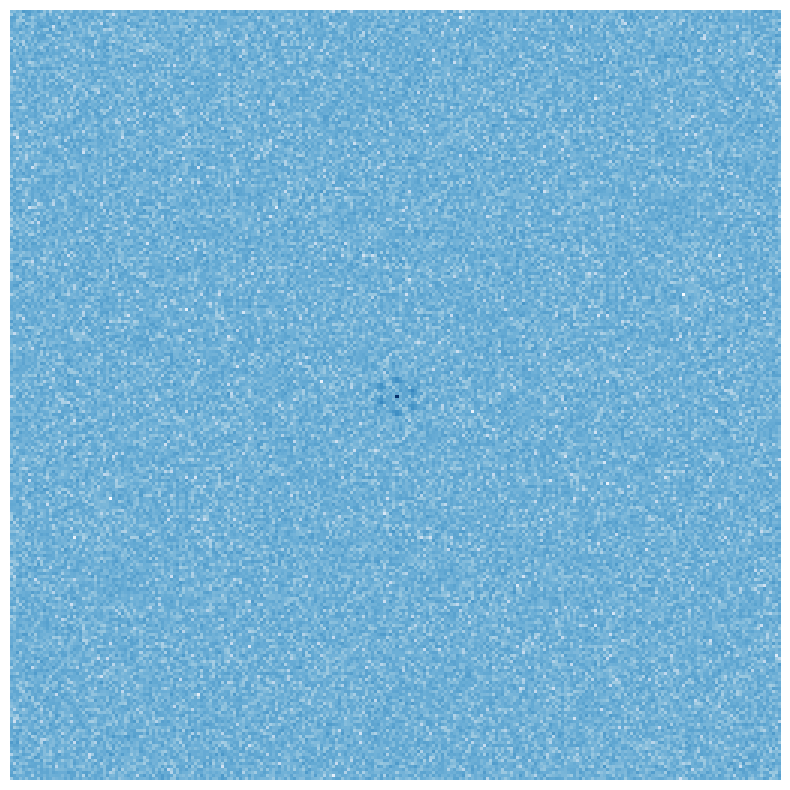

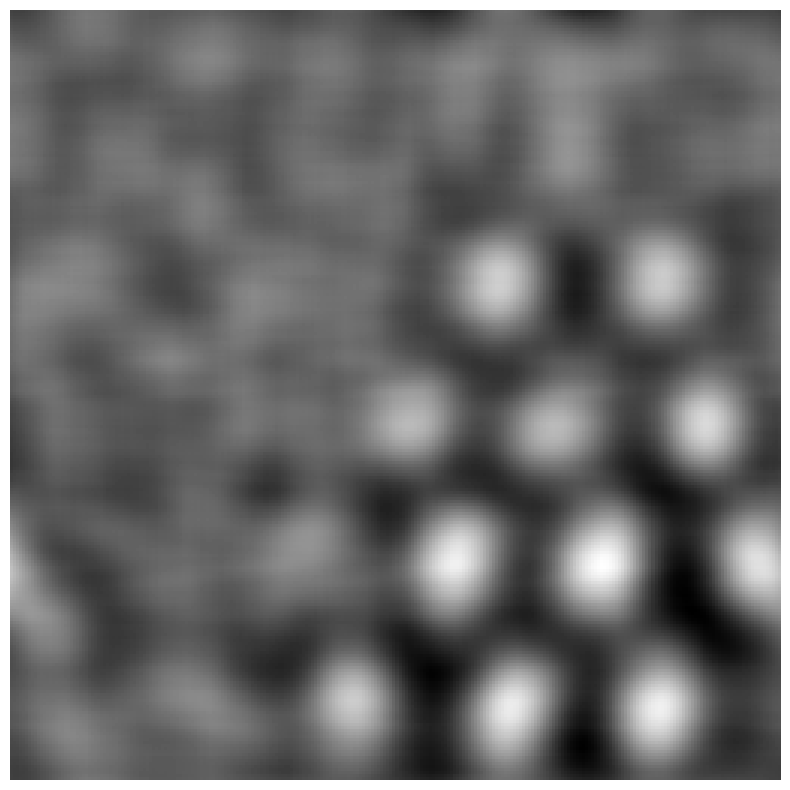

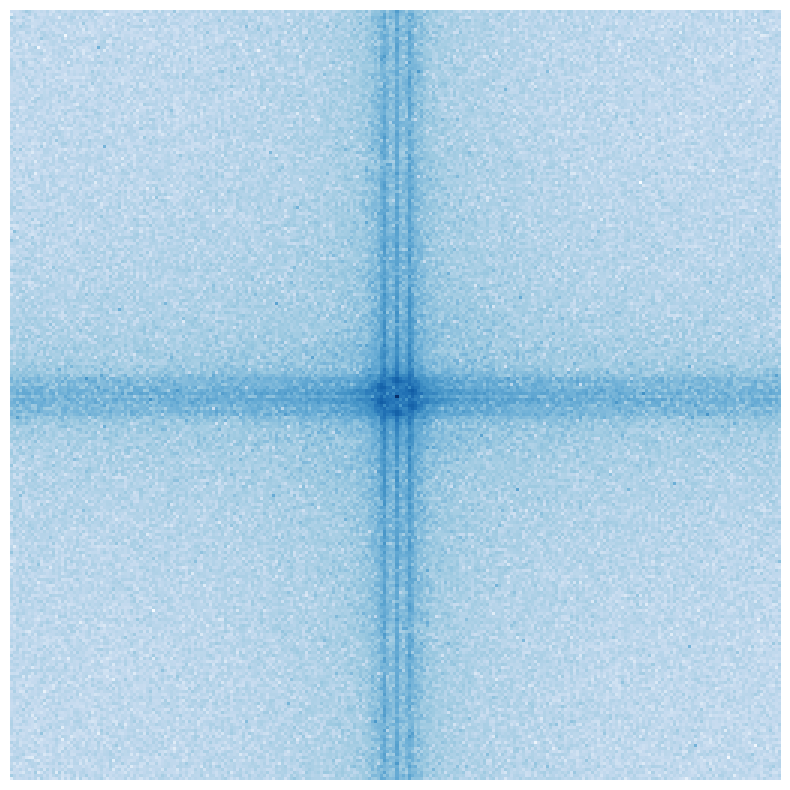

In [ ]:
import numpy as np
from PIL import Image
import torch
path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
# image_np = np.array(Image.open(path).resize((256,256)))
image_np = np.array(Image.open(path))

save_dir = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/results_compare/wiener/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

image_tensor = torch.tensor(image_np).unsqueeze(0)
clean_tmpt = image_tensor.unsqueeze(0)

# for noise_std in noise_std_array:
#     print('='*50 +'\n\n')
#     print('Noise Std: ', noise_std)

visualize_best_wiener_denoising_save(image_tensor[:,140:396,130:386].to(device), wiener_star, fft_sample=(256, 256), noise_scale=noise_scale, save_dir=save_dir)

In [ ]:
count = 0
noise_std = noise_scale
output_directory_root = 'output_mc_fig1_v2'
for idx, data in enumerate(test_loader.dataset):

    image_tensor = data['image']
    print(image_tensor.shape)
    compare_all(image_tensor,noise_std, wiener_star,
                               onelayer_net_dict[noise_std][49], net_dict['White-4-128'], fft_sample = (256, 256),noise_scale=noise_scale, output_directory = os.path.join(output_directory_root, str(idx)))
    count += 1
    if count > 50:
        break

In [ ]:
def load_model_multi(checkpoint_path):
    state_dict = torch.load( checkpoint_path, map_location=lambda s,
                                l: default_restore_location(s,"cpu"))

    args = argparse.Namespace(
        **{**vars(state_dict["args"])})
    model = models_microscopy.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model

In [ ]:
diff_checkpoint_path = {
    'White-4-128': '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/checkpoints/unet-128-small.pt',
    # 'White-6-128': '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/checkpoints/unet-128-big.pt',
    'noise2noise': '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/'
}

In [ ]:
net_dict = {}
for key, checkpoint_path in diff_checkpoint_path.items():
    net_dict[key] = load_model(checkpoint_path).to(device)
    print(f" {key} with parameters {sum(p.numel() for p in net_dict[key].parameters()):,}")

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# plt.rcParams['axes.titlesize'] = 16

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

def save_image(img, filename):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img, aspect='equal', cmap='gray')
    fig.savefig(filename, dpi=300)
    plt.close(fig)



def save_fft(img, filename):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img, aspect='equal', cmap=plt.cm.Blues)
    fig.savefig(filename, dpi=300)
    plt.close(fig)



def compare_three_images(source, noise_std, unet, unet2, unet3, figsize=(25, 10), fft_sample=(180, 180),noise_scale=50, output_directory="output_images_mc"):
    noisy = source + get_noise(source, noise_std=noise_std)
#     wavelet_denoised = net(noisy.unsqueeze(0))
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)


    # linear_denoised = net_linear(noisy.unsqueeze(0))
    unet_denoised = unet(noisy.to(device).unsqueeze(0))
    unet_denoised2 = unet2(noisy.to(device).unsqueeze(0))
    unet_denoised3 = unet3(noisy.to(device).unsqueeze(0))
    source_torch = source.clone().unsqueeze(0)
    source = source.numpy()[0]
    noisy = noisy.numpy()[0]

    psnr_noisy = round(compare_psnr(source,  noisy, data_range=1.), 2)
#     psnr_denoised = round(compare_psnr(source_ifft, denoised_ifft, data_range=1.), 2)
# #     psnr_wavelet = round(batch_PSNR(torch.clamp(wavelet_denoised, 0.0, 1.0), source_torch, 1.), 2)
#     psnr_linear = round(batch_PSNR(torch.clamp(linear_denoised, 0.0, 1.0), source_torch, 1.), 2)
    psnr_unet = round(batch_PSNR(torch.clamp(unet_denoised, 0.0, 1.0), source_torch, 1.), 2)
    psnr_unet2 = round(batch_PSNR(torch.clamp(unet_denoised2, 0.0, 1.0), source_torch, 1.), 2)
    psnr_unet3 = round(batch_PSNR(torch.clamp(unet_denoised3, 0.0, 1.0), source_torch, 1.), 2)

    fig, axes = plt.subplots(1, 5, sharex=True, sharey='row', figsize=figsize)

    images = [source, noisy,  tensor_to_image(unet_denoised), tensor_to_image(unet_denoised2), tensor_to_image(unet_denoised3)]
    titles = ["Source", f"Noisy Image: {psnr_noisy}", f"Supervised Denoised: {psnr_unet}", f"noise2noise Denoised: {psnr_unet2}", f"neighbor2neighbor Denoised: {psnr_unet3}"]

    # Display images
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
        filename = os.path.join(output_directory, title.replace(" ", "_").replace(":", "") + ".pdf")
        save_image(img, filename)


    # Remove the axis and figure border
    ax.axis('off')
    for spine in ax.spines.values():
        spine.set_visible(False)



    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    fig.savefig('comparison_plot_piecewise_natural_image.pdf', bbox_inches='tight', dpi=300)


In [ ]:
import numpy as np
from PIL import Image
import torch
path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
# image_np = np.array(Image.open(path).resize((256,256)))
image_np = np.array(Image.open(path))


image_tensor = torch.tensor(image_np).unsqueeze(0).unsqueeze(0)
# clean_tmpt = image_tensor.unsqueeze(0)

# for noise_std in noise_std_array:
#     print('='*50 +'\n\n')
print('Possion Distribution')
visualize_denoising(image_tensor.to(device), net, figsize=(20, 10))
    # visualize_best_wiener_denoising(image_tensor, noise_std, wiener_star[noise_std], fft_sample=(image_np.shape[0], image_np.shape[1]))

In [ ]:
count = 0
output_directory_root = 'output_natural_fig4'
for data in test_loader:
    for idx in range(2):

        image_tensor = data[idx]
        compare_three_images(image_tensor,noise_std, BF_CNN, BF_CNN_noise2noise, BF_CNN_neighbor2neighbor, fft_sample = (256, 256),noise_scale=noise_scale,output_directory = os.path.join(output_directory_root, str(idx)))
        count += 1
        if count > 1:
            break